## IMPORTS

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import ctypes
import gc
import random
from PIL import Image, ImageOps, ImageEnhance
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block
from skimage import io, transform
from torchmetrics.functional.image import peak_signal_noise_ratio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
from torchmetrics import Accuracy
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(42)
libc = ctypes.CDLL("libc.so.6")

Total .npy files found: 26504
Sample files: ['no_sub_sim_46686872317518872994276029683156576222.npy', 'no_sub_sim_109899628136467767026502489644636839951.npy']
Shape of data in no_sub_sim_109899628136467767026502489644636839951.npy: (64, 64)
Data type: float64


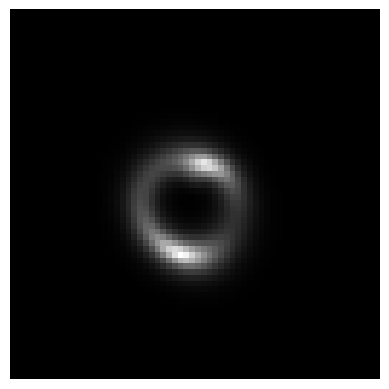

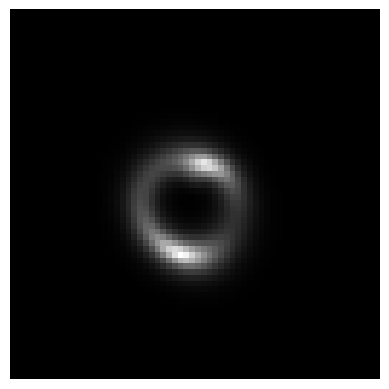

In [ ]:
no_sub_folder = "/kaggle/input/masked-autoencoder/train/no_sub" 
npy_files = [f for f in os.listdir(no_sub_folder) if f.endswith('.npy')]

print(f"Total .npy files found: {len(npy_files)}")
print("Sample files:", npy_files[:2]) 


sample_file = os.path.join(no_sub_folder, npy_files[100])
data = np.load(sample_file)

##Hardcoded normalisation, can be improved
data_norm = data.astype(np.float32) / 255.0

print(f"Shape of data in {npy_files[1]}: {data.shape}")
print(f"Data type: {data.dtype}")


# Display image
image = data 
image_norm = data_norm
if image.shape[-1] == 1:  
    image = image.squeeze() 
if image_norm.shape[-1] == 1:  
    image_norm = image_norm.squeeze() 
plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
plt.axis("off")
plt.show()

plt.imshow(image_norm, cmap='gray' if len(image_norm.shape) == 2 else None)
plt.axis("off")
plt.show()

## HELPER FUNCTIONS

## PIXEL VALUE RANGE

In [ ]:
data_dir = "/kaggle/input/masked-autoencoder/train/no_sub" 
npy_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]

# Select a few random files to inspect
num_samples = 5
selected_files = random.sample(npy_files, min(num_samples, len(npy_files)))


for file in selected_files:
    file_path = os.path.join(data_dir, file)
    img_array = np.load(file_path)  # Load the .npy file
    
    # Print file name and pixel statistics
    print(f"Shape: {img_array.shape}")
    print(f"Min Pixel Value: {img_array.min()}")
    print(f"Max Pixel Value: {img_array.max()}")



In [ ]:
##Helper functions

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def patchify(imgs, img_size, patch_size, in_chans, embed_dim):
    """
    imgs: (N, in_chans, H, W)
    x: (N, L, patch_size**2 *in_chans)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    
    # in_ch is 1
    x = imgs.reshape(shape=(imgs.shape[0], in_chans, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * in_chans))
    return x

def unpatchify(x, img_size, patch_size, in_chans, embed_dim):
    """
    x: (N, L, patch_size**2 *in_chans)
    imgs: (N, in_chans, H, W)
    """
    patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, in_chans))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], in_chans, h * p, h * p))
    return imgs

## MODEL ENCODER & DECODER

In [4]:

'''
Reference:
https://github.com/facebookresearch/mae/blob/main/models_mae.py
'''
class Encoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, mask_ratio = 0.75,
                 embed_dim=256, depth=12, num_heads=8,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = mask_ratio
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        # embed patches
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :] # add pos embed w/o cls token

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore
    
class Decoder(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=1, embed_dim = 256,
                 decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = patchify(imgs, 64, 4, 1, 256)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss

    def forward(self, imgs):
        latent, mask, ids_restore = self.encoder(imgs)
        pred = self.decoder(latent, ids_restore)
        bce_loss = self.forward_loss(imgs, pred, mask)
        
        return bce_loss, pred, mask


## MAKSED AUTOENCODER (MAE)

In [5]:
def mae_vit_base(img_size=64, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=4, in_chans= 1,mask_ratio = 0.75,
        embed_dim=256, depth=8, num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=4, in_chans = 1, embed_dim=256,
        decoder_embed_dim=128, decoder_depth=4, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

## DATALOADERS & AUGMENTATIONS

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
        self.transform = transform
        
    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npy_files[idx])
        data = np.load(file_path).astype(np.float32) # Load the .npy file
        img = data/255  # Single normalised image
    
        if self.transform:
            img = self.transform(img)
    
        return {'img': img}

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

train_split = '/kaggle/input/masked-autoencoder/train/no_sub'
val_split = '/kaggle/input/masked-autoencoder/val/no_sub'
train_dataset = CustomDataset(train_split, transform=transform)
val_dataset = CustomDataset(val_split, transform=transform)


# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)


In [8]:
def visualize_prediction(pred):
    preds = unpatchify(pred, 64, 4, 1, 256)[0]
    img = preds.permute(1, 2, 0).cpu().detach().numpy()

    num_channels = img.shape[2]

    # Create a single row of subplots
    fig, axes = plt.subplots(1, num_channels, figsize=(16, 4))

    # Ensure axes is iterable
    if num_channels == 1:
        axes = [axes]  # Convert to a list for consistent indexing

    # Iterate through channels and plot each one in a subplot
    for i in range(num_channels):
        axes[i].imshow(img[:, :, i], cmap="gray")  # Adjust colormap as needed
        axes[i].set_title(f'Channel {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## INITIALIZE MODEL

In [9]:
model = mae_vit_base(img_size=64)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 7250320


## TRAINING

The first 100 epochs were trained with augmentations. 
Train, Val batch sizes = 512
We now resume training for 250 epochs with no augmentations.

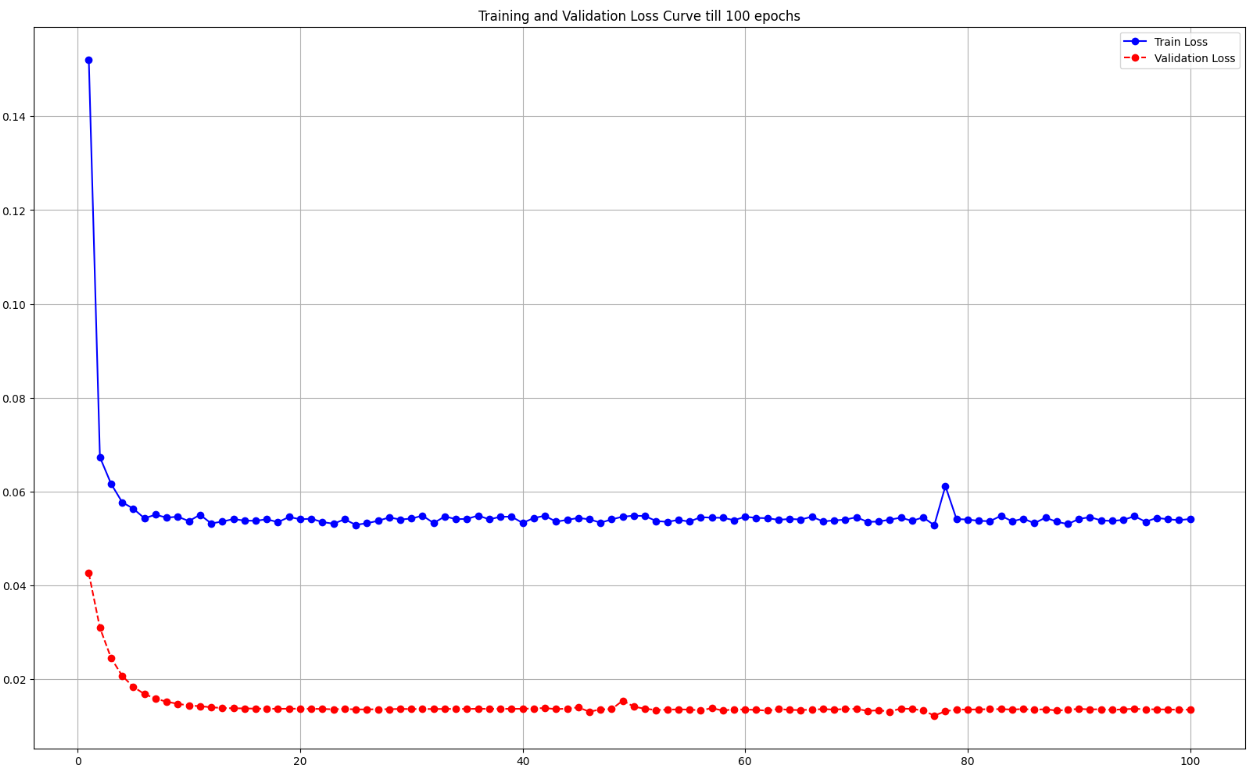

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR

def train_model(model, epochs, train_dataloader, val_dataloader, device):
    optimizer = AdamW(model.parameters(), lr=8e-4, weight_decay=0.05)
    
    # Cosine Annealing for first 10 epochs
    cosine_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)
    
    # MultiStepLR
    milestones = [30, 60, 80, 120, 150, 200, 250]
    multi_step_scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.7)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            optimizer.zero_grad()
            images = batch['img'].to(device).float()
            
            loss, outputs, ind = model(images)
            loss = loss.sum()
            loss.backward()
            optimizer.step()

            train_loss += loss
            
            # Use Cosine Annealing for first 25 epochs
            if epoch < 25:
                cosine_scheduler.step()
        
        # Compute average train loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Val)', unit='batch'):
                images = batch['img'].to(device).float()
                loss, val_outputs, ind = model(images)
                loss = loss.sum()
                val_loss += loss
        
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Switch to MultiStepLR after 25 epochs
        if epoch >= 25:
            multi_step_scheduler.step()

        # Visualization every 5 epochs
        if epoch % 5 == 0:
            visualize_prediction(outputs)
            visualize_prediction(val_outputs)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'./best_mae_vit_model_256emb_final.pth')
            print(f" Best model saved with Val Loss: {best_val_loss:.9f}")

        # Clear cache
        torch.cuda.empty_cache()
        gc.collect()

    return train_losses, val_losses


<ipython-input-11-19a2141dc4a4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/kaggle/input/gsoc-weights/best_mae_vit_model_256emb.pth')
Epoch 1/250 (T

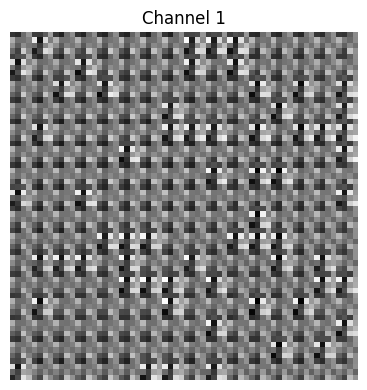

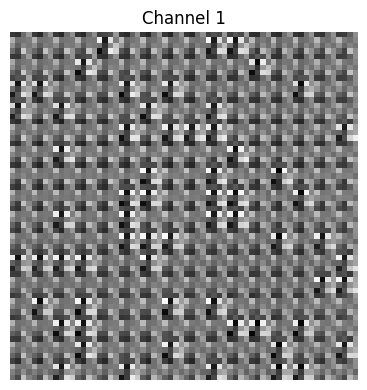

Epoch 1/250, Train Loss: 0.018815346, Val Loss: 0.009188158
 Best model saved with Val Loss: 0.009188158


Epoch 2/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 2/250, Train Loss: 0.008922585, Val Loss: 0.008678818
 Best model saved with Val Loss: 0.008678818


Epoch 3/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 3/250, Train Loss: 0.008582262, Val Loss: 0.008473356
 Best model saved with Val Loss: 0.008473356


Epoch 4/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch 4/250, Train Loss: 0.008438719, Val Loss: 0.008370956
 Best model saved with Val Loss: 0.008370956


Epoch 5/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 5/250, Train Loss: 0.008363320, Val Loss: 0.008322519
 Best model saved with Val Loss: 0.008322519


Epoch 6/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


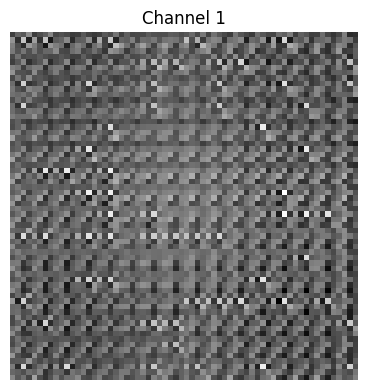

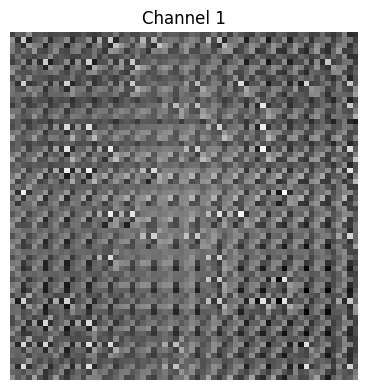

Epoch 6/250, Train Loss: 0.008322691, Val Loss: 0.008288049
 Best model saved with Val Loss: 0.008288049


Epoch 7/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch 7/250, Train Loss: 0.008297164, Val Loss: 0.008268113
 Best model saved with Val Loss: 0.008268113


Epoch 8/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 8/250, Train Loss: 0.008278144, Val Loss: 0.008249703
 Best model saved with Val Loss: 0.008249703


Epoch 9/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 9/250, Train Loss: 0.008258852, Val Loss: 0.008228065
 Best model saved with Val Loss: 0.008228065


Epoch 10/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch 10/250, Train Loss: 0.008235184, Val Loss: 0.008203203
 Best model saved with Val Loss: 0.008203203


Epoch 11/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


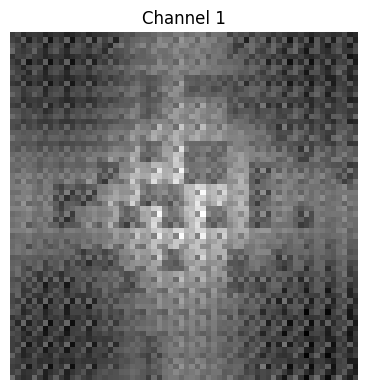

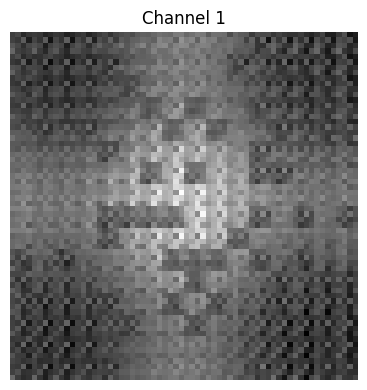

Epoch 11/250, Train Loss: 0.008198993, Val Loss: 0.008151579
 Best model saved with Val Loss: 0.008151579


Epoch 12/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 12/250, Train Loss: 0.008129558, Val Loss: 0.008047818
 Best model saved with Val Loss: 0.008047818


Epoch 13/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 13/250, Train Loss: 0.007920355, Val Loss: 0.007666485
 Best model saved with Val Loss: 0.007666485


Epoch 14/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 14/250, Train Loss: 0.007482240, Val Loss: 0.007303321
 Best model saved with Val Loss: 0.007303321


Epoch 15/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 15/250, Train Loss: 0.007216020, Val Loss: 0.007105587
 Best model saved with Val Loss: 0.007105587


Epoch 16/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


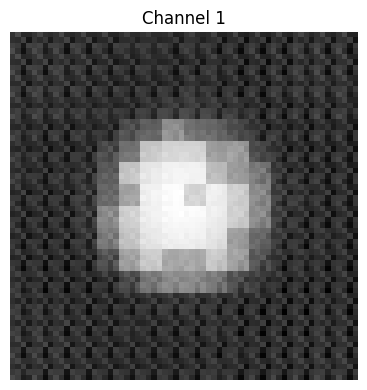

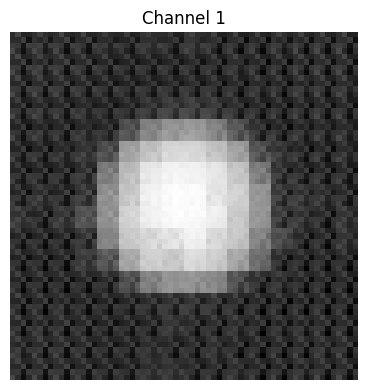

Epoch 16/250, Train Loss: 0.007044087, Val Loss: 0.006952637
 Best model saved with Val Loss: 0.006952637


Epoch 17/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 17/250, Train Loss: 0.006997311, Val Loss: 0.006934724
 Best model saved with Val Loss: 0.006934724


Epoch 18/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 18/250, Train Loss: 0.006882530, Val Loss: 0.006837386
 Best model saved with Val Loss: 0.006837386


Epoch 19/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 19/250, Train Loss: 0.006834767, Val Loss: 0.006796175
 Best model saved with Val Loss: 0.006796175


Epoch 20/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 20/250, Train Loss: 0.006816524, Val Loss: 0.006784571
 Best model saved with Val Loss: 0.006784571


Epoch 21/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


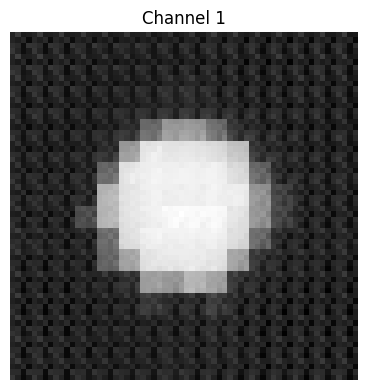

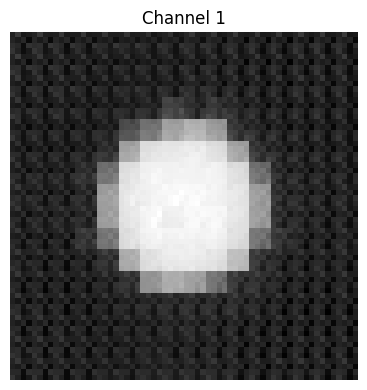

Epoch 21/250, Train Loss: 0.006824120, Val Loss: 0.006754096
 Best model saved with Val Loss: 0.006754096


Epoch 22/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 22/250, Train Loss: 0.006759775, Val Loss: 0.006738078
 Best model saved with Val Loss: 0.006738078


Epoch 23/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 23/250, Train Loss: 0.006756612, Val Loss: 0.006722891
 Best model saved with Val Loss: 0.006722891


Epoch 24/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 24/250, Train Loss: 0.006763557, Val Loss: 0.006814980


Epoch 25/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 25/250, Train Loss: 0.006747514, Val Loss: 0.006704509
 Best model saved with Val Loss: 0.006704509


Epoch 26/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


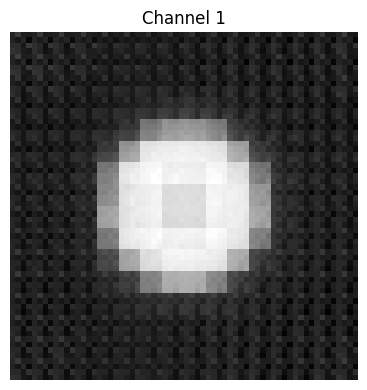

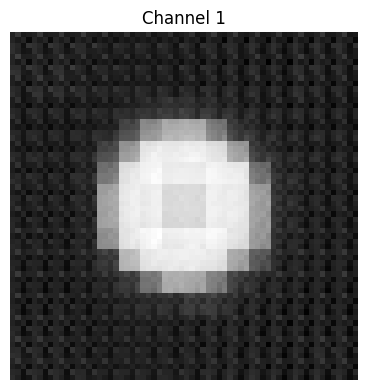

Epoch 26/250, Train Loss: 0.006716230, Val Loss: 0.006679944
 Best model saved with Val Loss: 0.006679944


Epoch 27/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 27/250, Train Loss: 0.006683249, Val Loss: 0.006660901
 Best model saved with Val Loss: 0.006660901


Epoch 28/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 28/250, Train Loss: 0.006668909, Val Loss: 0.006650166
 Best model saved with Val Loss: 0.006650166


Epoch 29/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 29/250, Train Loss: 0.006659876, Val Loss: 0.006643142
 Best model saved with Val Loss: 0.006643142


Epoch 30/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 30/250, Train Loss: 0.006653042, Val Loss: 0.006637178
 Best model saved with Val Loss: 0.006637178


Epoch 31/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


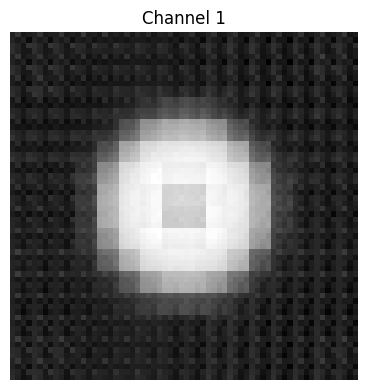

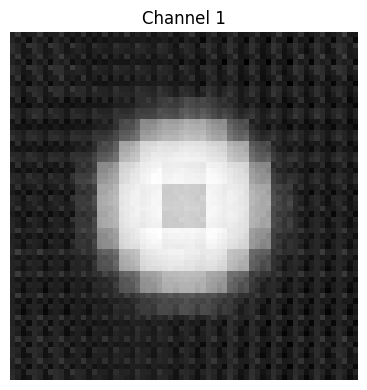

Epoch 31/250, Train Loss: 0.006647178, Val Loss: 0.006631084
 Best model saved with Val Loss: 0.006631084


Epoch 32/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 32/250, Train Loss: 0.006642335, Val Loss: 0.006626391
 Best model saved with Val Loss: 0.006626391


Epoch 33/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 33/250, Train Loss: 0.006638871, Val Loss: 0.006622890
 Best model saved with Val Loss: 0.006622890


Epoch 34/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 34/250, Train Loss: 0.006635885, Val Loss: 0.006620056
 Best model saved with Val Loss: 0.006620056


Epoch 35/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 35/250, Train Loss: 0.006634024, Val Loss: 0.006617762
 Best model saved with Val Loss: 0.006617762


Epoch 36/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


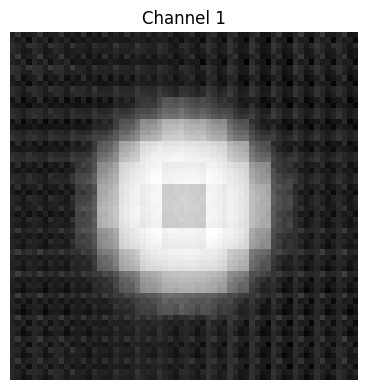

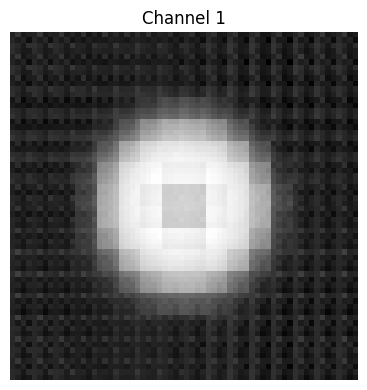

Epoch 36/250, Train Loss: 0.006630371, Val Loss: 0.006614648
 Best model saved with Val Loss: 0.006614648


Epoch 37/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 37/250, Train Loss: 0.006628721, Val Loss: 0.006611936
 Best model saved with Val Loss: 0.006611936


Epoch 38/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 38/250, Train Loss: 0.006626048, Val Loss: 0.006611304
 Best model saved with Val Loss: 0.006611304


Epoch 39/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 39/250, Train Loss: 0.006623351, Val Loss: 0.006609658
 Best model saved with Val Loss: 0.006609658


Epoch 40/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 40/250, Train Loss: 0.006622941, Val Loss: 0.006607331
 Best model saved with Val Loss: 0.006607331


Epoch 41/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


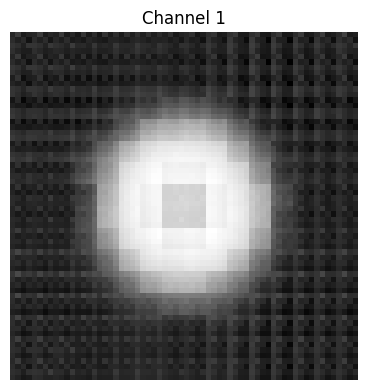

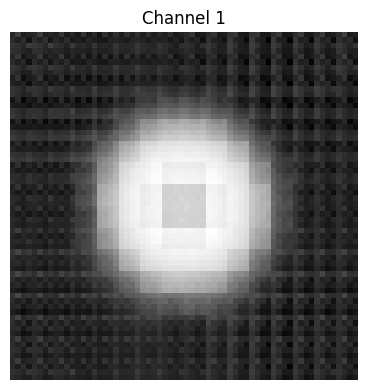

Epoch 41/250, Train Loss: 0.006617688, Val Loss: 0.006602481
 Best model saved with Val Loss: 0.006602481


Epoch 42/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 42/250, Train Loss: 0.006616895, Val Loss: 0.006612123


Epoch 43/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 43/250, Train Loss: 0.006620172, Val Loss: 0.006608509


Epoch 44/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s]


Epoch 44/250, Train Loss: 0.006613387, Val Loss: 0.006598254
 Best model saved with Val Loss: 0.006598254


Epoch 45/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 45/250, Train Loss: 0.006610272, Val Loss: 0.006596986
 Best model saved with Val Loss: 0.006596986


Epoch 46/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


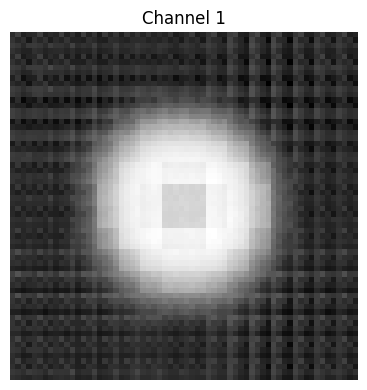

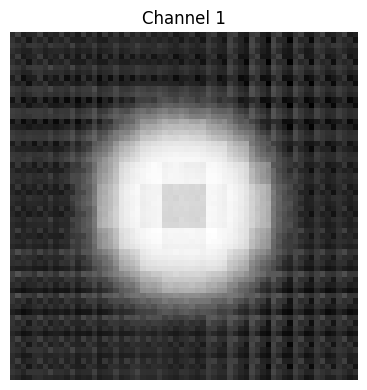

Epoch 46/250, Train Loss: 0.006608473, Val Loss: 0.006593390
 Best model saved with Val Loss: 0.006593390


Epoch 47/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 47/250, Train Loss: 0.006608734, Val Loss: 0.006592910
 Best model saved with Val Loss: 0.006592910


Epoch 48/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 48/250, Train Loss: 0.006617687, Val Loss: 0.006635416


Epoch 49/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 49/250, Train Loss: 0.006613346, Val Loss: 0.006589546
 Best model saved with Val Loss: 0.006589546


Epoch 50/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 50/250, Train Loss: 0.006602077, Val Loss: 0.006588617
 Best model saved with Val Loss: 0.006588617


Epoch 51/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


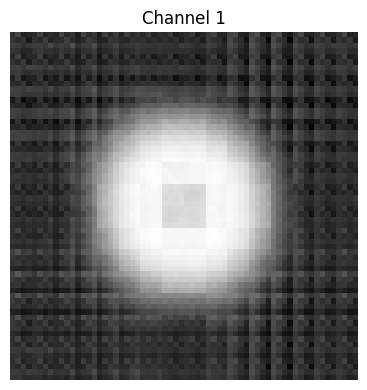

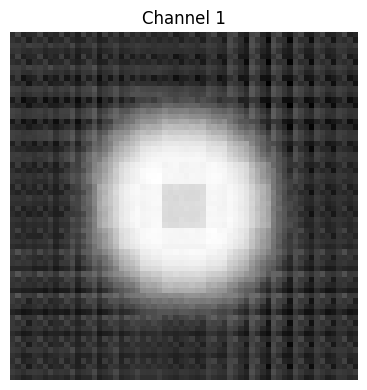

Epoch 51/250, Train Loss: 0.006600250, Val Loss: 0.006586393
 Best model saved with Val Loss: 0.006586393


Epoch 52/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.07s/batch]


Epoch 52/250, Train Loss: 0.006599726, Val Loss: 0.006584766
 Best model saved with Val Loss: 0.006584766


Epoch 53/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s]


Epoch 53/250, Train Loss: 0.006598923, Val Loss: 0.006583917
 Best model saved with Val Loss: 0.006583917


Epoch 54/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 54/250, Train Loss: 0.006597162, Val Loss: 0.006596053


Epoch 55/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 55/250, Train Loss: 0.006600270, Val Loss: 0.006586183


Epoch 56/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


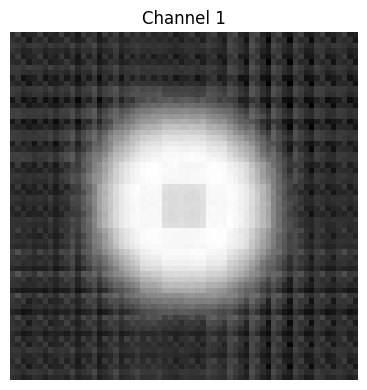

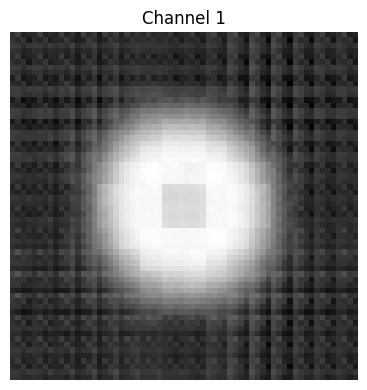

Epoch 56/250, Train Loss: 0.006595533, Val Loss: 0.006580412
 Best model saved with Val Loss: 0.006580412


Epoch 57/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 57/250, Train Loss: 0.006593160, Val Loss: 0.006579116
 Best model saved with Val Loss: 0.006579116


Epoch 58/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 58/250, Train Loss: 0.006591761, Val Loss: 0.006577676
 Best model saved with Val Loss: 0.006577676


Epoch 59/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 59/250, Train Loss: 0.006589776, Val Loss: 0.006584386


Epoch 60/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.04s/batch]


Epoch 60/250, Train Loss: 0.006591873, Val Loss: 0.006579159


Epoch 61/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


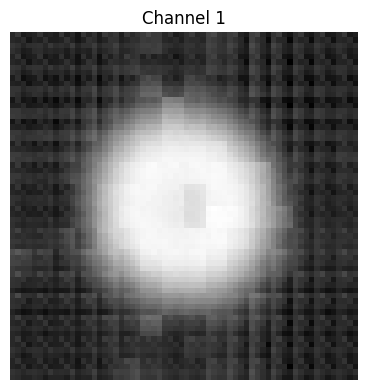

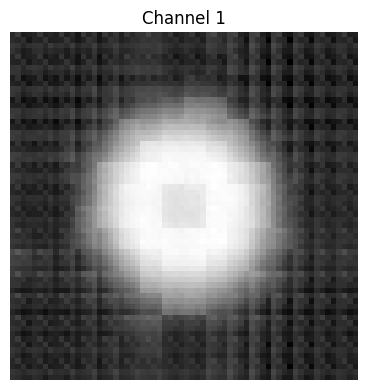

Epoch 61/250, Train Loss: 0.006596937, Val Loss: 0.006614632


Epoch 62/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 62/250, Train Loss: 0.006591560, Val Loss: 0.006554961
 Best model saved with Val Loss: 0.006554961


Epoch 63/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 63/250, Train Loss: 0.006655055, Val Loss: 0.006616912


Epoch 64/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.05s/batch]


Epoch 64/250, Train Loss: 0.006588349, Val Loss: 0.006533587
 Best model saved with Val Loss: 0.006533587


Epoch 65/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch]


Epoch 65/250, Train Loss: 0.006538041, Val Loss: 0.006518939
 Best model saved with Val Loss: 0.006518939


Epoch 66/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.04s/batch]


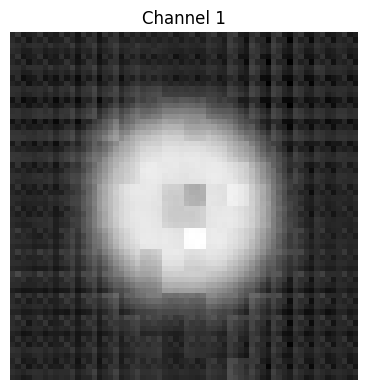

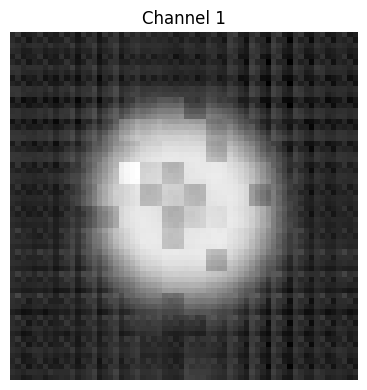

Epoch 66/250, Train Loss: 0.006528517, Val Loss: 0.006515543
 Best model saved with Val Loss: 0.006515543


Epoch 67/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 67/250, Train Loss: 0.006524748, Val Loss: 0.006509098
 Best model saved with Val Loss: 0.006509098


Epoch 68/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 68/250, Train Loss: 0.006520717, Val Loss: 0.006504767
 Best model saved with Val Loss: 0.006504767


Epoch 69/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 69/250, Train Loss: 0.006518031, Val Loss: 0.006502654
 Best model saved with Val Loss: 0.006502654


Epoch 70/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 70/250, Train Loss: 0.006516707, Val Loss: 0.006506465


Epoch 71/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


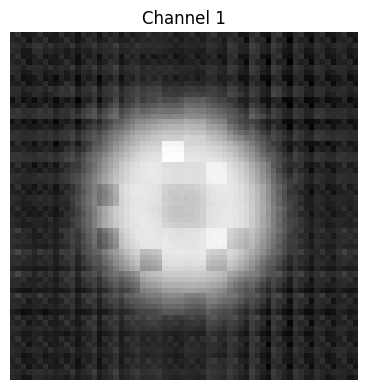

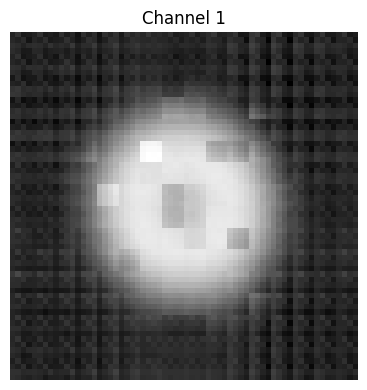

Epoch 71/250, Train Loss: 0.006515135, Val Loss: 0.006501306
 Best model saved with Val Loss: 0.006501306


Epoch 72/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 72/250, Train Loss: 0.006511467, Val Loss: 0.006498456
 Best model saved with Val Loss: 0.006498456


Epoch 73/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 73/250, Train Loss: 0.006510782, Val Loss: 0.006496703
 Best model saved with Val Loss: 0.006496703


Epoch 74/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 74/250, Train Loss: 0.006509753, Val Loss: 0.006495043
 Best model saved with Val Loss: 0.006495043


Epoch 75/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 75/250, Train Loss: 0.006510787, Val Loss: 0.006499194


Epoch 76/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


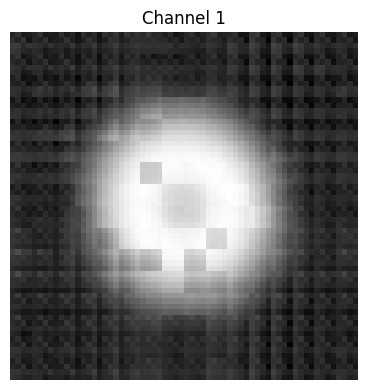

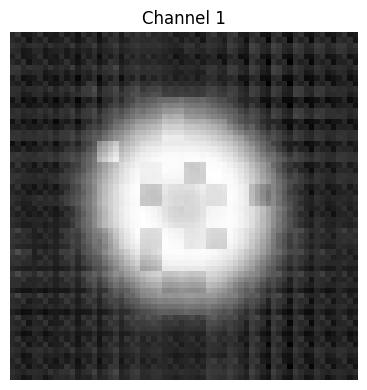

Epoch 76/250, Train Loss: 0.006509688, Val Loss: 0.006494892
 Best model saved with Val Loss: 0.006494892


Epoch 77/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 77/250, Train Loss: 0.006506447, Val Loss: 0.006492889
 Best model saved with Val Loss: 0.006492889


Epoch 78/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 78/250, Train Loss: 0.006508977, Val Loss: 0.006492400
 Best model saved with Val Loss: 0.006492400


Epoch 79/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 79/250, Train Loss: 0.006504437, Val Loss: 0.006490569
 Best model saved with Val Loss: 0.006490569


Epoch 80/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 80/250, Train Loss: 0.006502477, Val Loss: 0.006488563
 Best model saved with Val Loss: 0.006488563


Epoch 81/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


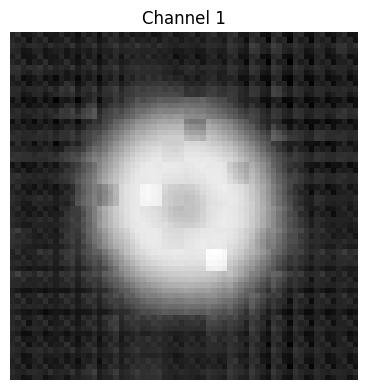

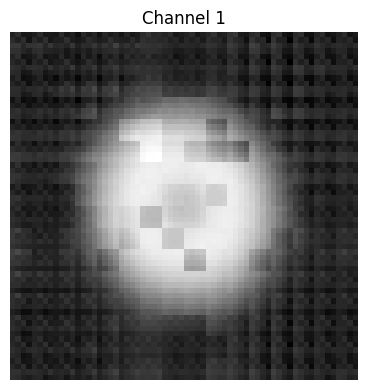

Epoch 81/250, Train Loss: 0.006500112, Val Loss: 0.006481633
 Best model saved with Val Loss: 0.006481633


Epoch 82/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 82/250, Train Loss: 0.006491524, Val Loss: 0.006467767
 Best model saved with Val Loss: 0.006467767


Epoch 83/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 83/250, Train Loss: 0.006496480, Val Loss: 0.006459333
 Best model saved with Val Loss: 0.006459333


Epoch 84/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 84/250, Train Loss: 0.006457611, Val Loss: 0.006431936
 Best model saved with Val Loss: 0.006431936


Epoch 85/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 85/250, Train Loss: 0.006445658, Val Loss: 0.006419300
 Best model saved with Val Loss: 0.006419300


Epoch 86/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


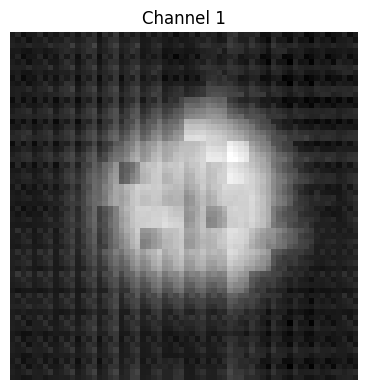

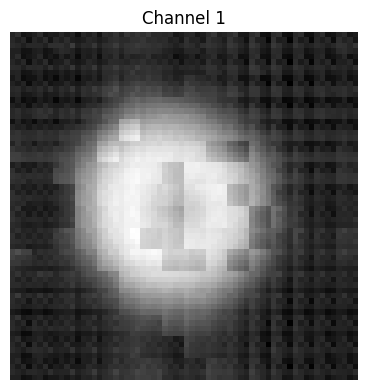

Epoch 86/250, Train Loss: 0.006418448, Val Loss: 0.006398675
 Best model saved with Val Loss: 0.006398675


Epoch 87/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 87/250, Train Loss: 0.006398770, Val Loss: 0.006368744
 Best model saved with Val Loss: 0.006368744


Epoch 88/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 88/250, Train Loss: 0.006405003, Val Loss: 0.006375288


Epoch 89/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 89/250, Train Loss: 0.006382116, Val Loss: 0.006359078
 Best model saved with Val Loss: 0.006359078


Epoch 90/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 90/250, Train Loss: 0.006372460, Val Loss: 0.006352860
 Best model saved with Val Loss: 0.006352860


Epoch 91/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


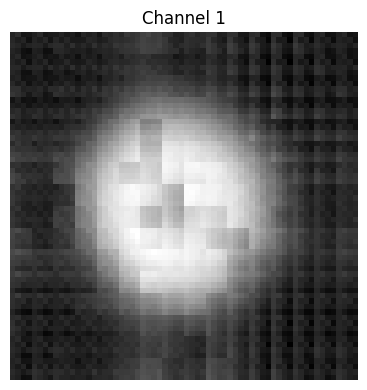

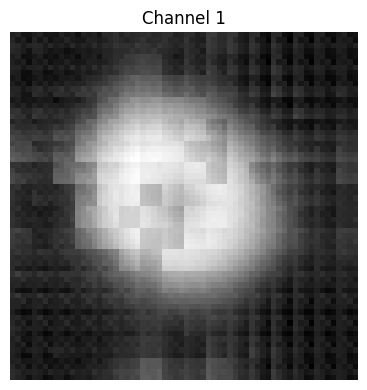

Epoch 91/250, Train Loss: 0.006399077, Val Loss: 0.006375480


Epoch 92/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 92/250, Train Loss: 0.006383216, Val Loss: 0.006337733
 Best model saved with Val Loss: 0.006337733


Epoch 93/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 93/250, Train Loss: 0.006340050, Val Loss: 0.006328627
 Best model saved with Val Loss: 0.006328627


Epoch 94/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 94/250, Train Loss: 0.006341665, Val Loss: 0.006317766
 Best model saved with Val Loss: 0.006317766


Epoch 95/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 95/250, Train Loss: 0.006352399, Val Loss: 0.006309777
 Best model saved with Val Loss: 0.006309777


Epoch 96/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.00s/batch]


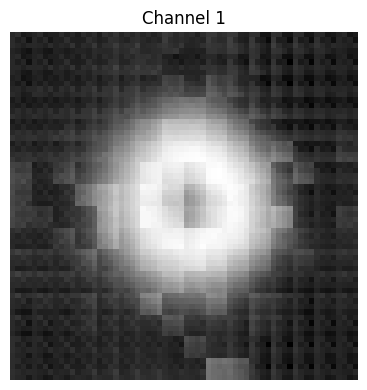

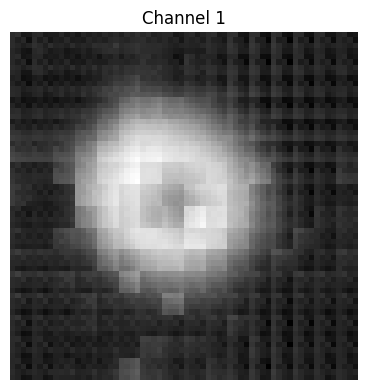

Epoch 96/250, Train Loss: 0.006333912, Val Loss: 0.006328772


Epoch 97/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 97/250, Train Loss: 0.006319254, Val Loss: 0.006294630
 Best model saved with Val Loss: 0.006294630


Epoch 98/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 98/250, Train Loss: 0.006313757, Val Loss: 0.006309626


Epoch 99/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 99/250, Train Loss: 0.006308069, Val Loss: 0.006293964
 Best model saved with Val Loss: 0.006293964


Epoch 100/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 100/250, Train Loss: 0.006333150, Val Loss: 0.006317291


Epoch 101/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


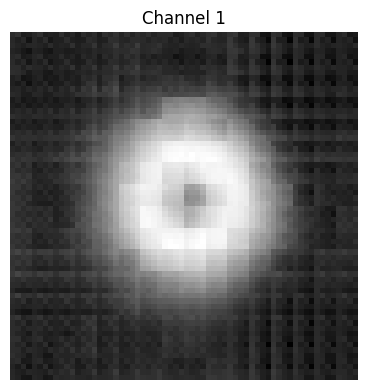

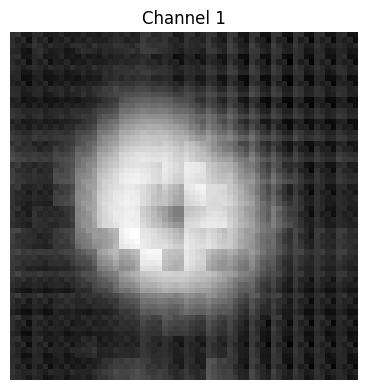

Epoch 101/250, Train Loss: 0.006303694, Val Loss: 0.006285508
 Best model saved with Val Loss: 0.006285508


Epoch 102/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.20s/batch]


Epoch 102/250, Train Loss: 0.006293181, Val Loss: 0.006274550
 Best model saved with Val Loss: 0.006274550


Epoch 103/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch]


Epoch 103/250, Train Loss: 0.006282343, Val Loss: 0.006277179


Epoch 104/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.04s/batch]


Epoch 104/250, Train Loss: 0.006284753, Val Loss: 0.006266657
 Best model saved with Val Loss: 0.006266657


Epoch 105/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 105/250, Train Loss: 0.006281694, Val Loss: 0.006265334
 Best model saved with Val Loss: 0.006265334


Epoch 106/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


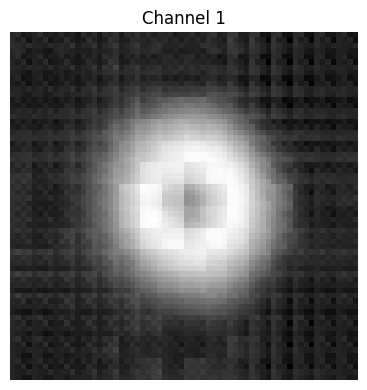

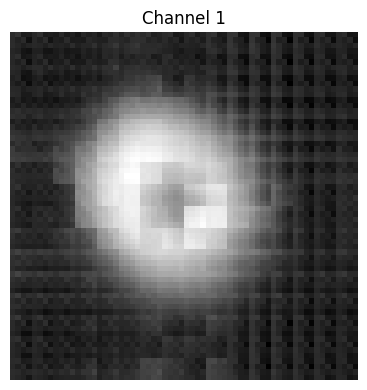

Epoch 106/250, Train Loss: 0.006270836, Val Loss: 0.006251141
 Best model saved with Val Loss: 0.006251141


Epoch 107/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 107/250, Train Loss: 0.006267118, Val Loss: 0.006254148


Epoch 108/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 108/250, Train Loss: 0.006279154, Val Loss: 0.006264029


Epoch 109/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 109/250, Train Loss: 0.006266459, Val Loss: 0.006247172
 Best model saved with Val Loss: 0.006247172


Epoch 110/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 110/250, Train Loss: 0.006266165, Val Loss: 0.006248957


Epoch 111/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


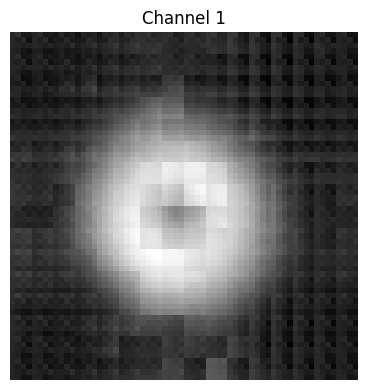

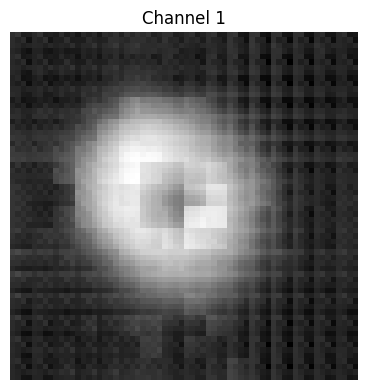

Epoch 111/250, Train Loss: 0.006258956, Val Loss: 0.006246915
 Best model saved with Val Loss: 0.006246915


Epoch 112/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 112/250, Train Loss: 0.006259301, Val Loss: 0.006240921
 Best model saved with Val Loss: 0.006240921


Epoch 113/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 113/250, Train Loss: 0.006266938, Val Loss: 0.006259271


Epoch 114/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 114/250, Train Loss: 0.006262731, Val Loss: 0.006242334


Epoch 115/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 115/250, Train Loss: 0.006251789, Val Loss: 0.006245906


Epoch 116/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


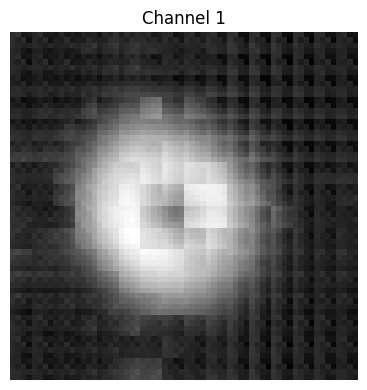

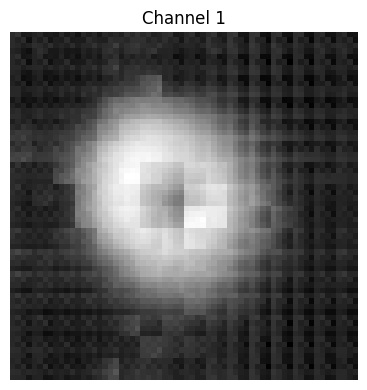

Epoch 116/250, Train Loss: 0.006255511, Val Loss: 0.006233478
 Best model saved with Val Loss: 0.006233478


Epoch 117/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 117/250, Train Loss: 0.006247783, Val Loss: 0.006233383
 Best model saved with Val Loss: 0.006233383


Epoch 118/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 118/250, Train Loss: 0.006249975, Val Loss: 0.006236418


Epoch 119/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 119/250, Train Loss: 0.006260924, Val Loss: 0.006241187


Epoch 120/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 120/250, Train Loss: 0.006247986, Val Loss: 0.006231170
 Best model saved with Val Loss: 0.006231170


Epoch 121/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


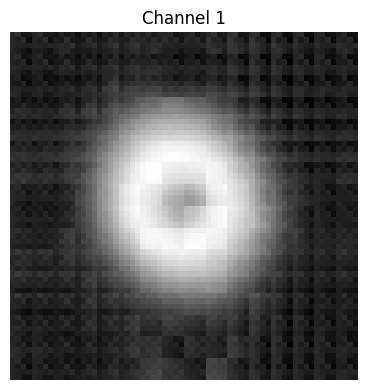

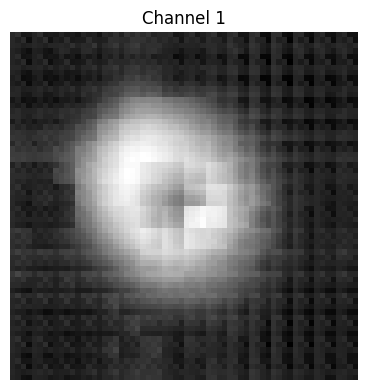

Epoch 121/250, Train Loss: 0.006243374, Val Loss: 0.006227651
 Best model saved with Val Loss: 0.006227651


Epoch 122/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 122/250, Train Loss: 0.006251222, Val Loss: 0.006231917


Epoch 123/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 123/250, Train Loss: 0.006241890, Val Loss: 0.006230412


Epoch 124/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 124/250, Train Loss: 0.006242638, Val Loss: 0.006225709
 Best model saved with Val Loss: 0.006225709


Epoch 125/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 125/250, Train Loss: 0.006239490, Val Loss: 0.006225389
 Best model saved with Val Loss: 0.006225389


Epoch 126/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


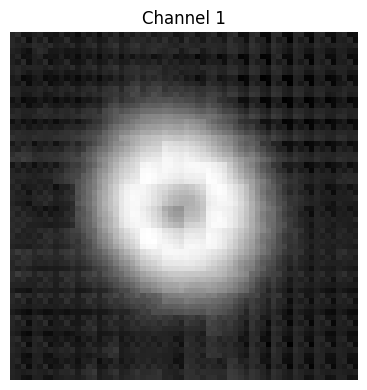

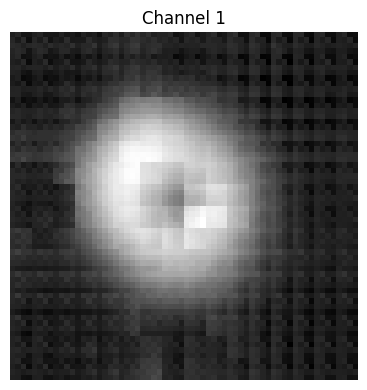

Epoch 126/250, Train Loss: 0.006236933, Val Loss: 0.006224209
 Best model saved with Val Loss: 0.006224209


Epoch 127/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 127/250, Train Loss: 0.006237785, Val Loss: 0.006222680
 Best model saved with Val Loss: 0.006222680


Epoch 128/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 128/250, Train Loss: 0.006239652, Val Loss: 0.006222554
 Best model saved with Val Loss: 0.006222554


Epoch 129/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 129/250, Train Loss: 0.006233055, Val Loss: 0.006217311
 Best model saved with Val Loss: 0.006217311


Epoch 130/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 130/250, Train Loss: 0.006232521, Val Loss: 0.006216695
 Best model saved with Val Loss: 0.006216695


Epoch 131/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


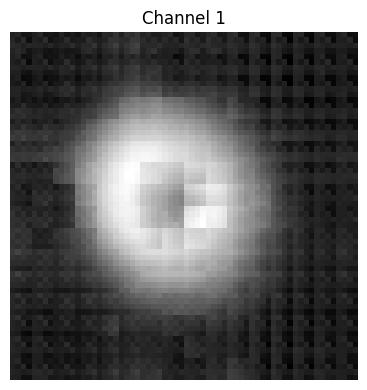

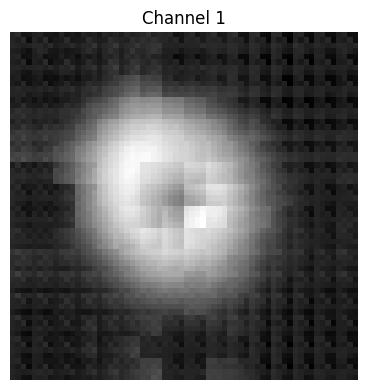

Epoch 131/250, Train Loss: 0.006234098, Val Loss: 0.006218913


Epoch 132/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 132/250, Train Loss: 0.006233408, Val Loss: 0.006222956


Epoch 133/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 133/250, Train Loss: 0.006234836, Val Loss: 0.006218816


Epoch 134/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 134/250, Train Loss: 0.006232352, Val Loss: 0.006215622
 Best model saved with Val Loss: 0.006215622


Epoch 135/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 135/250, Train Loss: 0.006226596, Val Loss: 0.006211611
 Best model saved with Val Loss: 0.006211611


Epoch 136/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


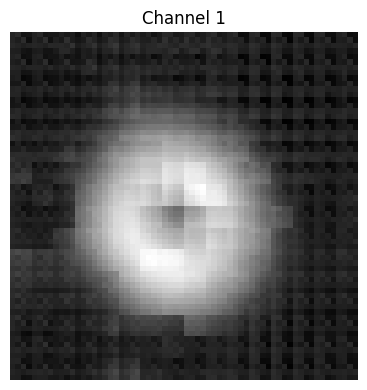

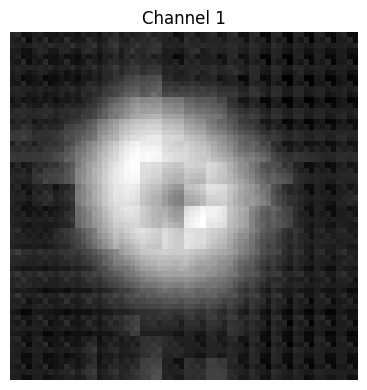

Epoch 136/250, Train Loss: 0.006235723, Val Loss: 0.006218511


Epoch 137/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 137/250, Train Loss: 0.006226171, Val Loss: 0.006209574
 Best model saved with Val Loss: 0.006209574


Epoch 138/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 138/250, Train Loss: 0.006223919, Val Loss: 0.006208390
 Best model saved with Val Loss: 0.006208390


Epoch 139/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 139/250, Train Loss: 0.006223680, Val Loss: 0.006211017


Epoch 140/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 140/250, Train Loss: 0.006223698, Val Loss: 0.006207220
 Best model saved with Val Loss: 0.006207220


Epoch 141/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


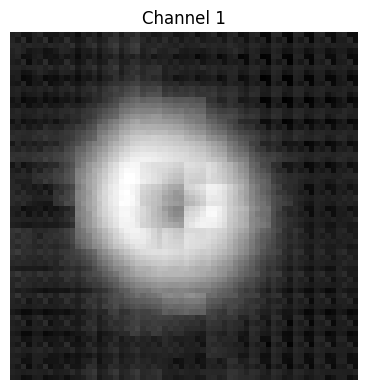

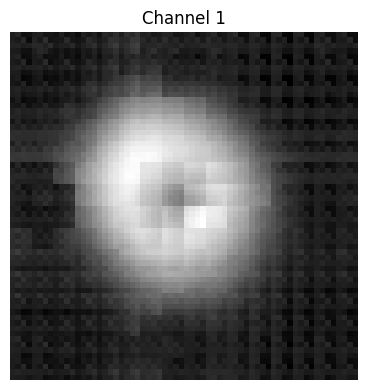

Epoch 141/250, Train Loss: 0.006223682, Val Loss: 0.006209285


Epoch 142/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 142/250, Train Loss: 0.006227412, Val Loss: 0.006229411


Epoch 143/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 143/250, Train Loss: 0.006235924, Val Loss: 0.006212249


Epoch 144/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 144/250, Train Loss: 0.006220648, Val Loss: 0.006203554
 Best model saved with Val Loss: 0.006203554


Epoch 145/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 145/250, Train Loss: 0.006217284, Val Loss: 0.006202196
 Best model saved with Val Loss: 0.006202196


Epoch 146/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


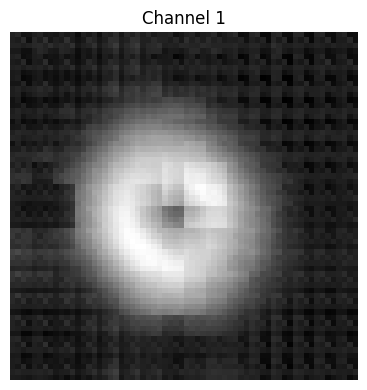

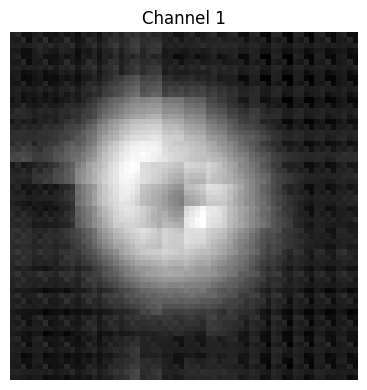

Epoch 146/250, Train Loss: 0.006214409, Val Loss: 0.006199851
 Best model saved with Val Loss: 0.006199851


Epoch 147/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 147/250, Train Loss: 0.006213243, Val Loss: 0.006199325
 Best model saved with Val Loss: 0.006199325


Epoch 148/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 148/250, Train Loss: 0.006212947, Val Loss: 0.006199320
 Best model saved with Val Loss: 0.006199320


Epoch 149/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 149/250, Train Loss: 0.006211165, Val Loss: 0.006197539
 Best model saved with Val Loss: 0.006197539


Epoch 150/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 150/250, Train Loss: 0.006210949, Val Loss: 0.006197089
 Best model saved with Val Loss: 0.006197089


Epoch 151/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


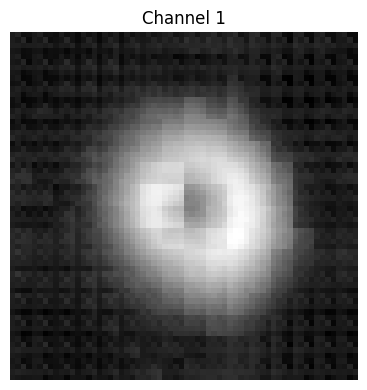

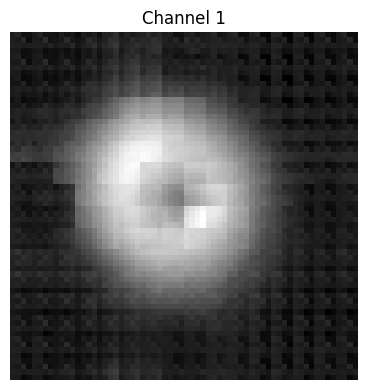

Epoch 151/250, Train Loss: 0.006209614, Val Loss: 0.006196948
 Best model saved with Val Loss: 0.006196948


Epoch 152/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch 152/250, Train Loss: 0.006210242, Val Loss: 0.006197135


Epoch 153/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 153/250, Train Loss: 0.006207948, Val Loss: 0.006193529
 Best model saved with Val Loss: 0.006193529


Epoch 154/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 154/250, Train Loss: 0.006207962, Val Loss: 0.006195481


Epoch 155/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 155/250, Train Loss: 0.006207468, Val Loss: 0.006196266


Epoch 156/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


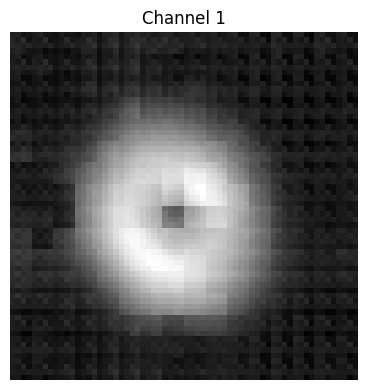

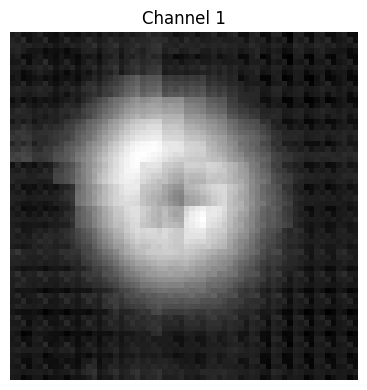

Epoch 156/250, Train Loss: 0.006206088, Val Loss: 0.006194567


Epoch 157/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 157/250, Train Loss: 0.006205625, Val Loss: 0.006191227
 Best model saved with Val Loss: 0.006191227


Epoch 158/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.10batch/s]


Epoch 158/250, Train Loss: 0.006208187, Val Loss: 0.006191344


Epoch 159/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 159/250, Train Loss: 0.006203407, Val Loss: 0.006188673
 Best model saved with Val Loss: 0.006188673


Epoch 160/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 160/250, Train Loss: 0.006202598, Val Loss: 0.006188243
 Best model saved with Val Loss: 0.006188243


Epoch 161/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


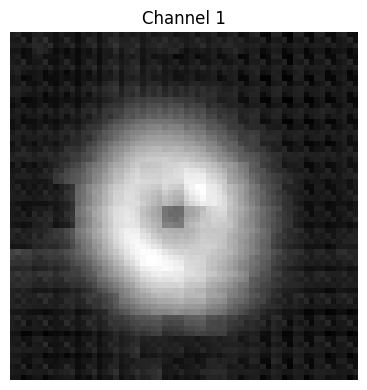

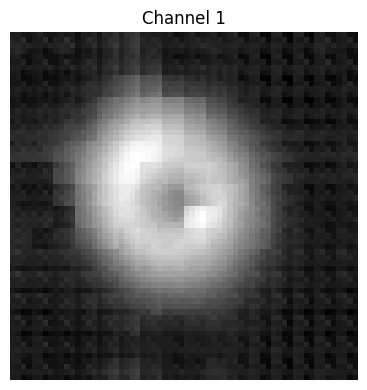

Epoch 161/250, Train Loss: 0.006202473, Val Loss: 0.006187598
 Best model saved with Val Loss: 0.006187598


Epoch 162/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 162/250, Train Loss: 0.006202866, Val Loss: 0.006187481
 Best model saved with Val Loss: 0.006187481


Epoch 163/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 163/250, Train Loss: 0.006202161, Val Loss: 0.006187421
 Best model saved with Val Loss: 0.006187421


Epoch 164/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 164/250, Train Loss: 0.006199988, Val Loss: 0.006187211
 Best model saved with Val Loss: 0.006187211


Epoch 165/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 165/250, Train Loss: 0.006205050, Val Loss: 0.006190152


Epoch 166/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s]


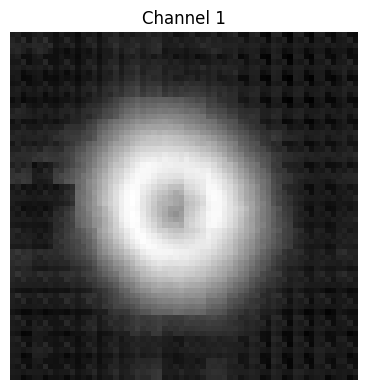

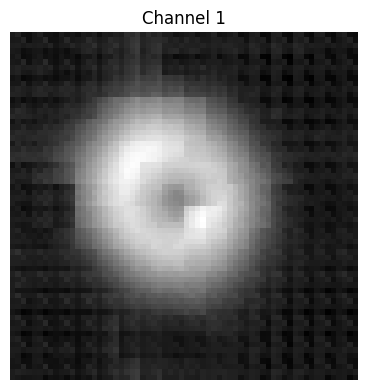

Epoch 166/250, Train Loss: 0.006201353, Val Loss: 0.006186590
 Best model saved with Val Loss: 0.006186590


Epoch 167/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 167/250, Train Loss: 0.006198605, Val Loss: 0.006187323


Epoch 168/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 168/250, Train Loss: 0.006201497, Val Loss: 0.006191146


Epoch 169/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 169/250, Train Loss: 0.006199053, Val Loss: 0.006183814
 Best model saved with Val Loss: 0.006183814


Epoch 170/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


Epoch 170/250, Train Loss: 0.006197188, Val Loss: 0.006181858
 Best model saved with Val Loss: 0.006181858


Epoch 171/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch]


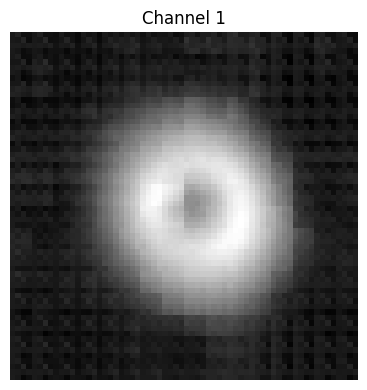

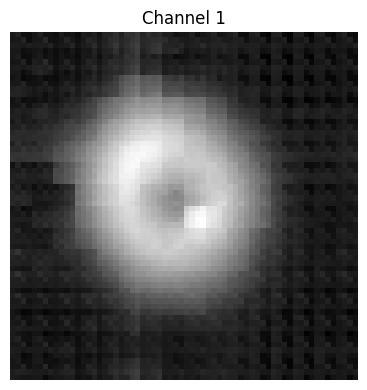

Epoch 171/250, Train Loss: 0.006195916, Val Loss: 0.006181825
 Best model saved with Val Loss: 0.006181825


Epoch 172/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 172/250, Train Loss: 0.006198208, Val Loss: 0.006183288


Epoch 173/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 173/250, Train Loss: 0.006195571, Val Loss: 0.006182042


Epoch 174/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 174/250, Train Loss: 0.006198656, Val Loss: 0.006180815
 Best model saved with Val Loss: 0.006180815


Epoch 175/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 175/250, Train Loss: 0.006194129, Val Loss: 0.006180413
 Best model saved with Val Loss: 0.006180413


Epoch 176/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.03batch/s]


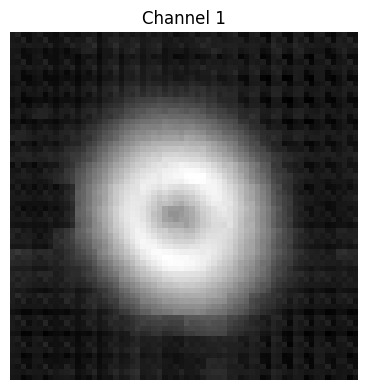

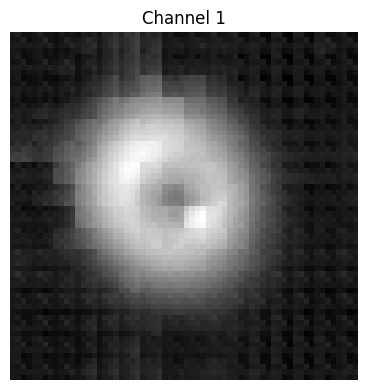

Epoch 176/250, Train Loss: 0.006193558, Val Loss: 0.006180442


Epoch 177/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 177/250, Train Loss: 0.006193039, Val Loss: 0.006178723
 Best model saved with Val Loss: 0.006178723


Epoch 178/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 178/250, Train Loss: 0.006192978, Val Loss: 0.006178584
 Best model saved with Val Loss: 0.006178584


Epoch 179/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 179/250, Train Loss: 0.006191873, Val Loss: 0.006178829


Epoch 180/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 180/250, Train Loss: 0.006192275, Val Loss: 0.006178252
 Best model saved with Val Loss: 0.006178252


Epoch 181/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


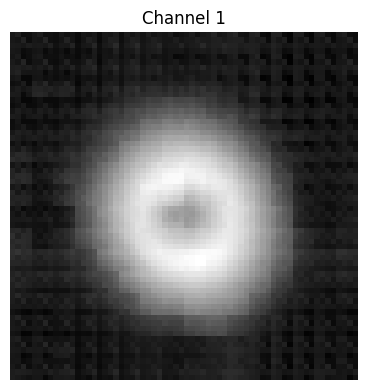

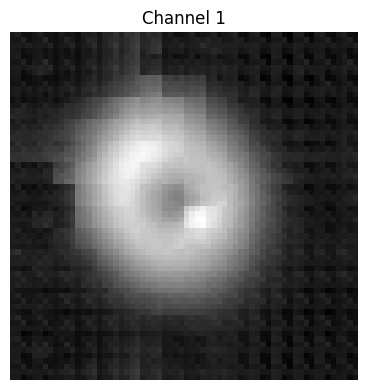

Epoch 181/250, Train Loss: 0.006193439, Val Loss: 0.006179392


Epoch 182/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch]


Epoch 182/250, Train Loss: 0.006192510, Val Loss: 0.006178101
 Best model saved with Val Loss: 0.006178101


Epoch 183/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 183/250, Train Loss: 0.006191565, Val Loss: 0.006177941
 Best model saved with Val Loss: 0.006177941


Epoch 184/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 184/250, Train Loss: 0.006191663, Val Loss: 0.006178408


Epoch 185/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 185/250, Train Loss: 0.006191930, Val Loss: 0.006177973


Epoch 186/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


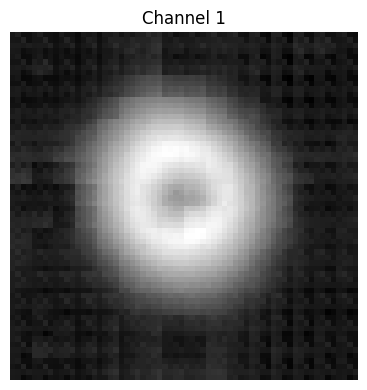

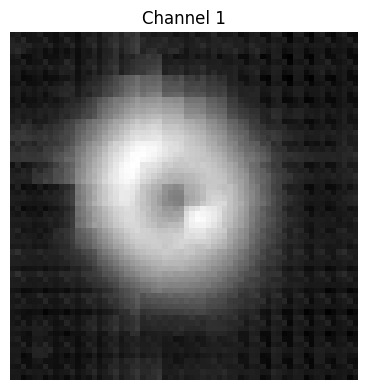

Epoch 186/250, Train Loss: 0.006191191, Val Loss: 0.006177390
 Best model saved with Val Loss: 0.006177390


Epoch 187/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 187/250, Train Loss: 0.006191358, Val Loss: 0.006177655


Epoch 188/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 188/250, Train Loss: 0.006190863, Val Loss: 0.006176516
 Best model saved with Val Loss: 0.006176516


Epoch 189/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 189/250, Train Loss: 0.006190966, Val Loss: 0.006176846


Epoch 190/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 190/250, Train Loss: 0.006192859, Val Loss: 0.006179835


Epoch 191/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


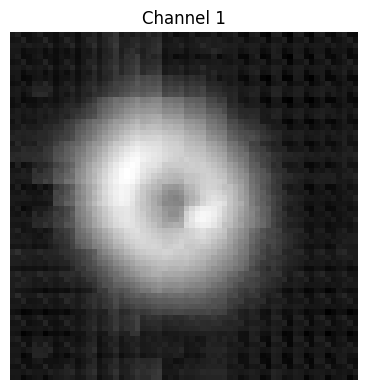

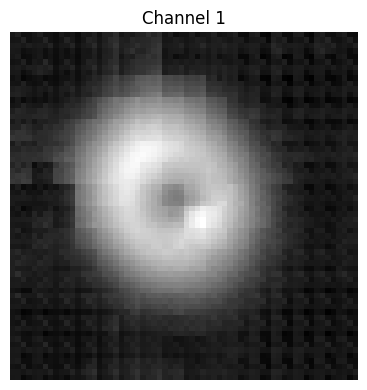

Epoch 191/250, Train Loss: 0.006192628, Val Loss: 0.006176945


Epoch 192/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.00s/batch]


Epoch 192/250, Train Loss: 0.006190259, Val Loss: 0.006177194


Epoch 193/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 193/250, Train Loss: 0.006190921, Val Loss: 0.006176971


Epoch 194/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 194/250, Train Loss: 0.006190580, Val Loss: 0.006177780


Epoch 195/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 195/250, Train Loss: 0.006190148, Val Loss: 0.006175479
 Best model saved with Val Loss: 0.006175479


Epoch 196/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


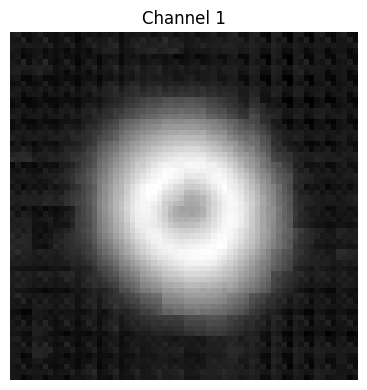

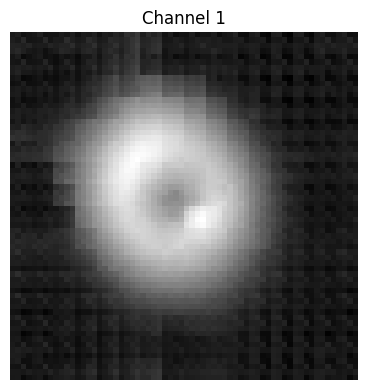

Epoch 196/250, Train Loss: 0.006189884, Val Loss: 0.006176797


Epoch 197/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 197/250, Train Loss: 0.006190565, Val Loss: 0.006176323


Epoch 198/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 198/250, Train Loss: 0.006189246, Val Loss: 0.006175264
 Best model saved with Val Loss: 0.006175264


Epoch 199/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 199/250, Train Loss: 0.006190286, Val Loss: 0.006175601


Epoch 200/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.01s/batch]


Epoch 200/250, Train Loss: 0.006189330, Val Loss: 0.006175386


Epoch 201/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


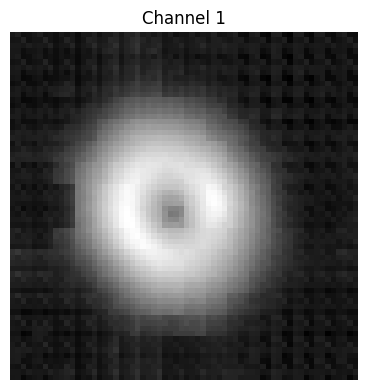

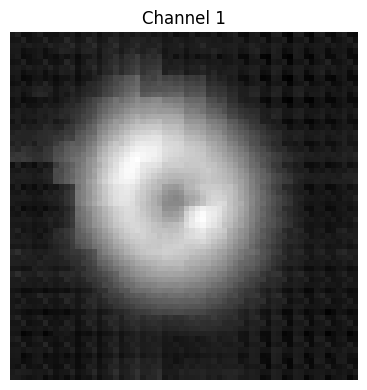

Epoch 201/250, Train Loss: 0.006190122, Val Loss: 0.006175464


Epoch 202/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 202/250, Train Loss: 0.006189293, Val Loss: 0.006175934


Epoch 203/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 203/250, Train Loss: 0.006189289, Val Loss: 0.006174849
 Best model saved with Val Loss: 0.006174849


Epoch 204/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 204/250, Train Loss: 0.006189352, Val Loss: 0.006175600


Epoch 205/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 205/250, Train Loss: 0.006188320, Val Loss: 0.006174568
 Best model saved with Val Loss: 0.006174568


Epoch 206/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


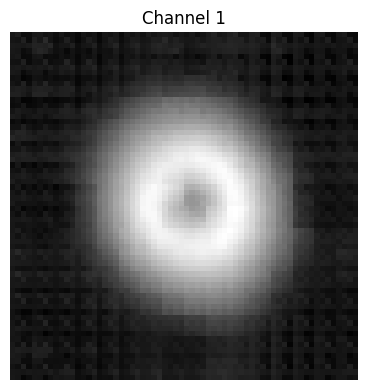

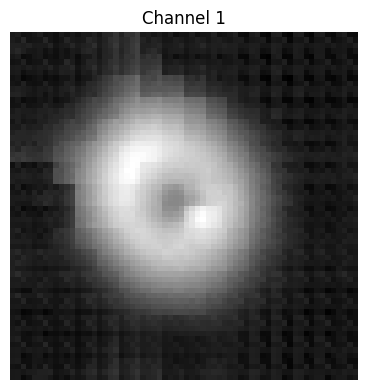

Epoch 206/250, Train Loss: 0.006188849, Val Loss: 0.006175714


Epoch 207/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 207/250, Train Loss: 0.006189757, Val Loss: 0.006174214
 Best model saved with Val Loss: 0.006174214


Epoch 208/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.04s/batch]


Epoch 208/250, Train Loss: 0.006188775, Val Loss: 0.006174765


Epoch 209/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 209/250, Train Loss: 0.006188943, Val Loss: 0.006175521


Epoch 210/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 210/250, Train Loss: 0.006188577, Val Loss: 0.006174256


Epoch 211/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s]


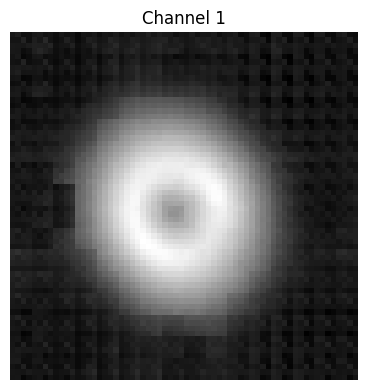

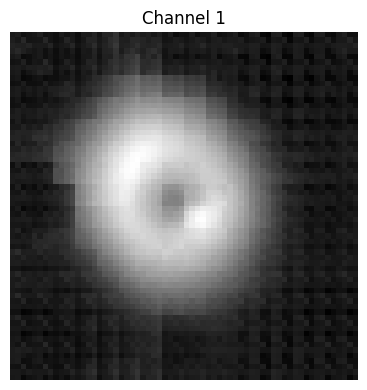

Epoch 211/250, Train Loss: 0.006188153, Val Loss: 0.006173698
 Best model saved with Val Loss: 0.006173698


Epoch 212/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 212/250, Train Loss: 0.006188678, Val Loss: 0.006179329


Epoch 213/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.01batch/s]


Epoch 213/250, Train Loss: 0.006189737, Val Loss: 0.006174016


Epoch 214/250 (Val): 100%|██████████| 3/3 [00:03<00:00,  1.02s/batch]


Epoch 214/250, Train Loss: 0.006187898, Val Loss: 0.006173365
 Best model saved with Val Loss: 0.006173365


Epoch 215/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 215/250, Train Loss: 0.006187443, Val Loss: 0.006173316
 Best model saved with Val Loss: 0.006173316


Epoch 216/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


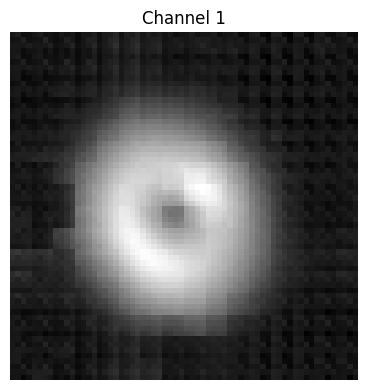

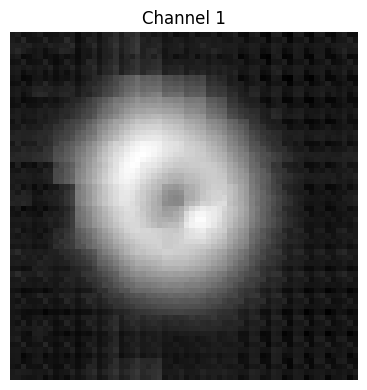

Epoch 216/250, Train Loss: 0.006187709, Val Loss: 0.006175834


Epoch 217/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 217/250, Train Loss: 0.006188863, Val Loss: 0.006173569


Epoch 218/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 218/250, Train Loss: 0.006187622, Val Loss: 0.006176563


Epoch 219/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 219/250, Train Loss: 0.006187892, Val Loss: 0.006172982
 Best model saved with Val Loss: 0.006172982


Epoch 220/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 220/250, Train Loss: 0.006187272, Val Loss: 0.006173496


Epoch 221/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


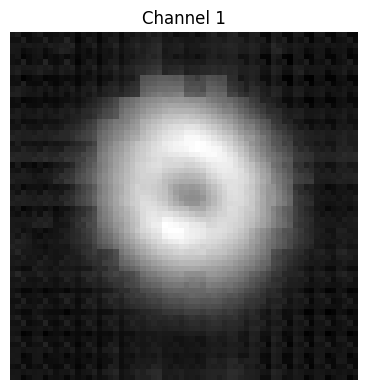

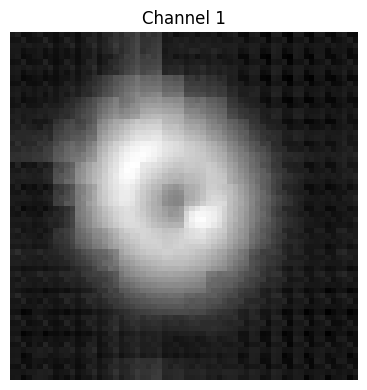

Epoch 221/250, Train Loss: 0.006188972, Val Loss: 0.006182573


Epoch 222/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.11batch/s]


Epoch 222/250, Train Loss: 0.006190996, Val Loss: 0.006174176


Epoch 223/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 223/250, Train Loss: 0.006187466, Val Loss: 0.006172733
 Best model saved with Val Loss: 0.006172733


Epoch 224/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 224/250, Train Loss: 0.006186622, Val Loss: 0.006174888


Epoch 225/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 225/250, Train Loss: 0.006186460, Val Loss: 0.006172470
 Best model saved with Val Loss: 0.006172470


Epoch 226/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


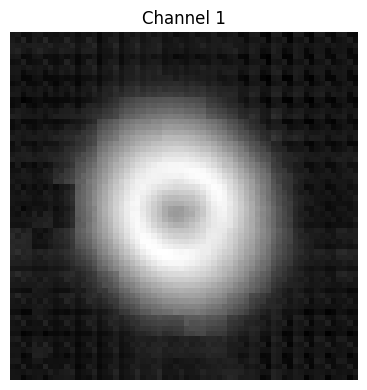

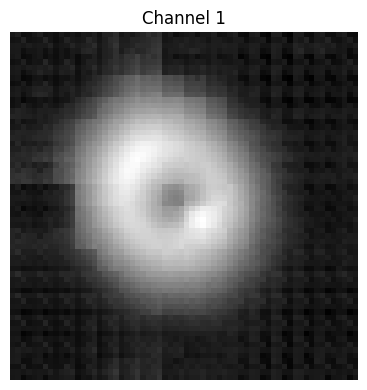

Epoch 226/250, Train Loss: 0.006186320, Val Loss: 0.006172068
 Best model saved with Val Loss: 0.006172068


Epoch 227/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 227/250, Train Loss: 0.006186249, Val Loss: 0.006172176


Epoch 228/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 228/250, Train Loss: 0.006185979, Val Loss: 0.006172254


Epoch 229/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.00batch/s]


Epoch 229/250, Train Loss: 0.006185874, Val Loss: 0.006171999
 Best model saved with Val Loss: 0.006171999


Epoch 230/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 230/250, Train Loss: 0.006185895, Val Loss: 0.006171872
 Best model saved with Val Loss: 0.006171872


Epoch 231/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


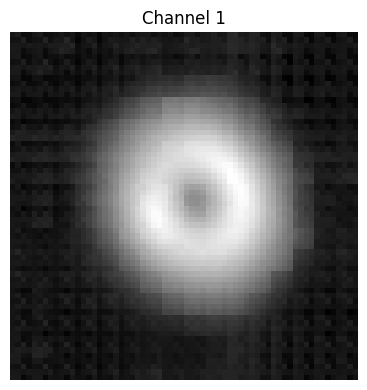

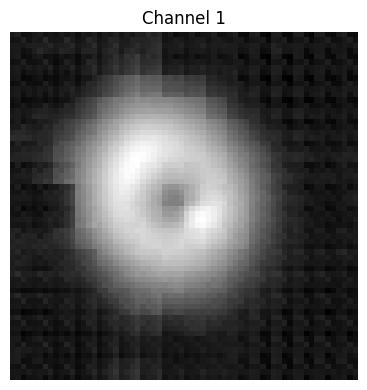

Epoch 231/250, Train Loss: 0.006186080, Val Loss: 0.006172187


Epoch 232/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 232/250, Train Loss: 0.006185585, Val Loss: 0.006172044


Epoch 233/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 233/250, Train Loss: 0.006185825, Val Loss: 0.006171977


Epoch 234/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


Epoch 234/250, Train Loss: 0.006185916, Val Loss: 0.006171835
 Best model saved with Val Loss: 0.006171835


Epoch 235/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 235/250, Train Loss: 0.006185716, Val Loss: 0.006171494
 Best model saved with Val Loss: 0.006171494


Epoch 236/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.08batch/s]


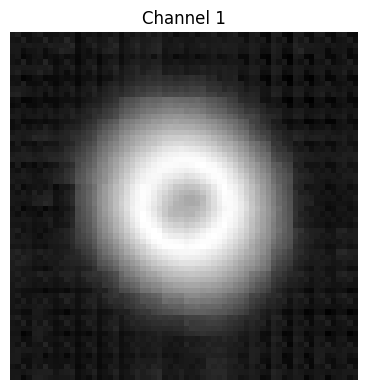

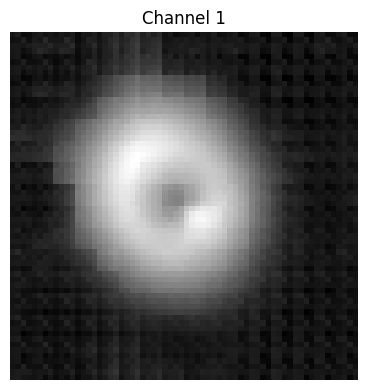

Epoch 236/250, Train Loss: 0.006185515, Val Loss: 0.006171823


Epoch 237/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.02batch/s]


Epoch 237/250, Train Loss: 0.006186201, Val Loss: 0.006172124


Epoch 238/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.09batch/s]


Epoch 238/250, Train Loss: 0.006185641, Val Loss: 0.006171640


Epoch 239/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 239/250, Train Loss: 0.006185148, Val Loss: 0.006172435


Epoch 240/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


Epoch 240/250, Train Loss: 0.006185627, Val Loss: 0.006171548


Epoch 241/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


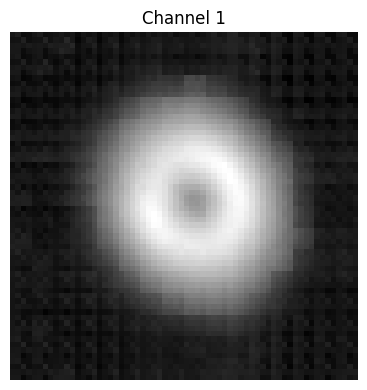

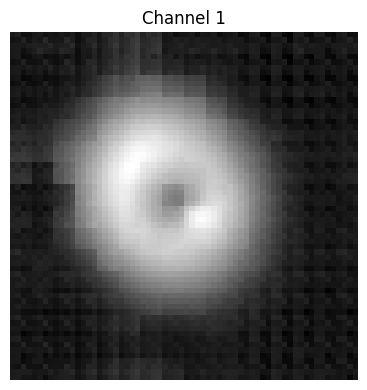

Epoch 241/250, Train Loss: 0.006185257, Val Loss: 0.006171347
 Best model saved with Val Loss: 0.006171347


Epoch 242/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 242/250, Train Loss: 0.006184787, Val Loss: 0.006171561


Epoch 243/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 243/250, Train Loss: 0.006185510, Val Loss: 0.006171246
 Best model saved with Val Loss: 0.006171246


Epoch 244/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.04batch/s]


Epoch 244/250, Train Loss: 0.006184881, Val Loss: 0.006171327


Epoch 245/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 245/250, Train Loss: 0.006185284, Val Loss: 0.006171451


Epoch 246/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.05batch/s]


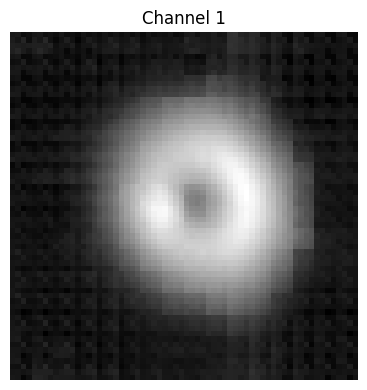

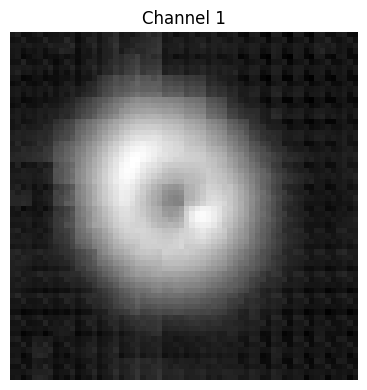

Epoch 246/250, Train Loss: 0.006184903, Val Loss: 0.006171210
 Best model saved with Val Loss: 0.006171210


Epoch 247/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 247/250, Train Loss: 0.006184907, Val Loss: 0.006171842


Epoch 248/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 248/250, Train Loss: 0.006185809, Val Loss: 0.006170968
 Best model saved with Val Loss: 0.006170968


Epoch 249/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s]


Epoch 249/250, Train Loss: 0.006184686, Val Loss: 0.006170904
 Best model saved with Val Loss: 0.006170904


Epoch 250/250 (Val): 100%|██████████| 3/3 [00:02<00:00,  1.06batch/s]


Epoch 250/250, Train Loss: 0.006184706, Val Loss: 0.006170992


In [11]:
DEVICE = torch.device("cuda:0")
NUM_GPU = torch.cuda.device_count()

model = model.to(DEVICE)
ckpt = torch.load('/kaggle/input/gsoc-weights/best_mae_vit_model_256emb.pth')
new_state_dict = {key.replace("module.", ""): value for key, value in ckpt.items()}
model.load_state_dict(new_state_dict)
if NUM_GPU > 1:
    model = nn.DataParallel(model)

epochs = 250

train_losses, val_losses = train_model(model, epochs, train_dataloader, val_dataloader, DEVICE)

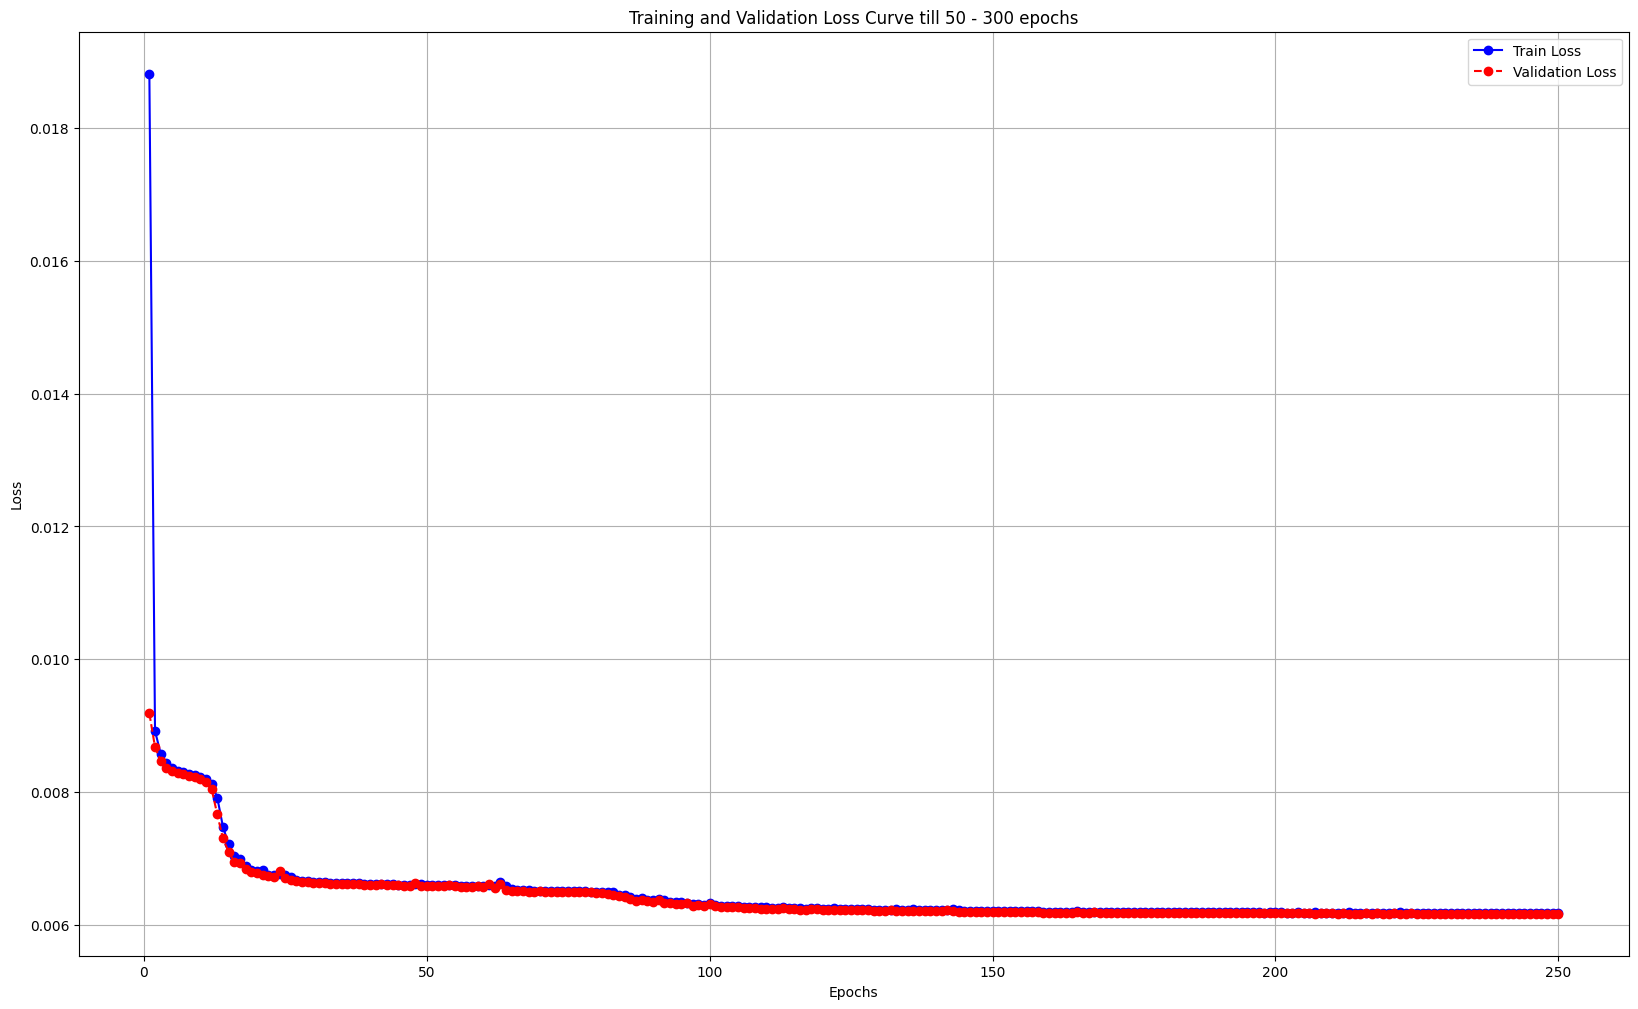

In [13]:


# Ensure train_losses and val_losses are on CPU & converted to NumPy
train_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# X-axis values (Epoch numbers)
x = list(range(1, len(train_losses) + 1))

# Plot
plt.figure(figsize=(20, 12))
plt.plot(x, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(x, val_losses, marker='o', linestyle='--', color='r', label='Validation Loss')

# Labels and Title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve till 50 - 300 epochs')
plt.legend()
plt.grid()

# Show Plot
plt.show()


In [14]:
def visualize_mae_reconstruction(model, image, device="cpu"):
    """
    Given an image, this function:
    1. Patchifies and masks the input
    2. Passes it through the MAE model
    3. Reconstructs the image
    4. Displays the original, masked, and reconstructed images side by side
    5. Calculates and displays reconstruction quality metrics
    
    Args:
        model (Masked_VIT): The trained Masked AutoEncoder model
        image (torch.Tensor): A single image tensor of shape (1, C, H, W)
        device (str): Device to run the model on ("cuda" or "cpu")
        
    Returns:
        tuple: Original image, masked image, reconstructed image, and metrics dictionary
    """
    
    model.to(device)
    model.eval()
    image = image.to(device)
    imgs = image
    # Forward pass through the MAE model
    with torch.no_grad():
        loss, pred, mask = model(image)
    
    # Print shapes to debug
    print(f"imgs shape: {imgs.shape}")
    print(f"pred shape: {pred.shape}")
    print(f"mask shape: {mask.shape}")
    
    # Get dimensions
    
    img_size = 64
    patch_size = 4
    in_chans = 1
    embed_dim = 256
    
    # Create visualization of masked patches, handling different possible shapes
    # Option 1: If imgs is already in patched form [B, L, D]
    if len(imgs.shape) == 3:
        masked_imgs = imgs * (1 - mask.unsqueeze(-1).expand_as(imgs))
    # Option 2: If imgs is in image form [B, C, H, W]
    elif len(imgs.shape) == 4:
        # First patchify the original image
        patched_imgs = patchify(imgs, img_size, patch_size, in_chans, embed_dim)
        # Then apply mask
        mask_expanded = mask.unsqueeze(-1).expand_as(patched_imgs)
        masked_imgs = patched_imgs * (1 - mask_expanded)
    else:
        raise ValueError(f"Unexpected shape for imgs: {imgs.shape}")
    
    # Unpatchify the predicted output and masked input
    reconstructed = unpatchify(pred, img_size, patch_size, in_chans, embed_dim)
    masked_vis = unpatchify(masked_imgs, img_size, patch_size, in_chans, embed_dim)
    
    # Convert tensors to numpy arrays for visualization
    orig_img = image.squeeze().cpu().numpy()  # Remove singleton dimensions
    masked_img = masked_vis.squeeze().cpu().numpy()
    recon_img = reconstructed.squeeze().cpu().numpy()
    
    # Get pixel-level mask by unpatchifying a tensor of ones with the same mask
    # Create a tensor of ones with the same shape as pred
    ones_tensor = torch.ones_like(pred)
    # Apply the mask (1 = masked, 0 = visible)
    masked_ones = ones_tensor * mask.unsqueeze(-1).expand_as(ones_tensor)
    # Unpatchify to get pixel-level mask
    pixel_mask = unpatchify(masked_ones, img_size, patch_size, in_chans, embed_dim)
    pixel_mask = pixel_mask.squeeze().cpu().numpy() > 0.5  # Convert to boolean mask
    
    # Calculate reconstruction quality metrics
    metrics = calculate_reconstruction_metrics(orig_img, recon_img, pixel_mask)
    
    # Plot the images with metrics
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(orig_img, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(masked_img, cmap="gray")
    ax[1].set_title("Masked Input")
    ax[1].axis("off")
    
    ax[2].imshow(recon_img, cmap="gray")
    metrics_text = f"Full MSE: {metrics['mse']:.4f}\nMasked MSE: {metrics['masked_mse']:.4f}\nPSNR: {metrics['psnr']:.2f} dB"
    ax[2].set_title(f"Reconstructed Image\n{metrics_text}")
    ax[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Also print metrics to console
    print(f"Reconstruction Metrics:")
    print(f"Full Image MSE: {metrics['mse']:.6f}")
    print(f"Masked Regions MSE: {metrics['masked_mse']:.6f}")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")
    
    return orig_img, masked_img, recon_img, metrics, pixel_mask

def calculate_reconstruction_metrics(original, reconstruction, mask=None):
    """
    Calculate metrics to evaluate reconstruction quality.
    """
    # Normalize images if necessary
    original = (original - original.min()) / (original.max() - original.min())
    reconstruction = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    
    mse = np.mean((original - reconstruction) ** 2)
    
    # Handle masked MSE properly
    if mask is not None and np.any(mask):
        masked_diff = (original - reconstruction) ** 2
        masked_mse = np.sum(masked_diff[mask]) / np.sum(mask)
    else:
        masked_mse = mse  # Default to full-image MSE if no mask

    # Fix data range for PSNR calculation
    psnr_val = psnr(original, reconstruction, data_range=1.0)  # Assuming normalized images

    # Structural Similarity Index (SSIM)
    ssim_val = ssim(original, reconstruction, data_range=1.0)

    return {'mse': mse, 'masked_mse': masked_mse, 'psnr': psnr_val, 'ssim': ssim_val}


def visualize_multiple_samples(model, dataloader, num_samples=5, device="cpu"):
    """
    Visualizes multiple samples from a dataloader with reconstruction metrics.
    
    Args:
        model (nn.Module): Trained MAE model
        dataloader: DataLoader containing images
        num_samples (int): Number of samples to visualize
        device (str): Device to run on
        
    Returns:
        dict: Average metrics across all samples
    """
    model.eval()
    
    # Collect metrics for all samples
    all_metrics = []
    
    for i, batch in enumerate(dataloader):
        if i >= num_samples:
            break
            
        images = batch['img'].to(device).float()
        
        # Pick the first image of the batch
        image = images[0:1]
        
        print(f"Sample {i+1}")
        _, _, _, metrics, _ = visualize_mae_reconstruction(model, image, device)
        all_metrics.append(metrics)
        print("\n")
    
    # Calculate and display average metrics
    if all_metrics:
        avg_metrics = {
            'mse': np.mean([m['mse'] for m in all_metrics]),
            'psnr': np.mean([m['psnr'] for m in all_metrics]),
            'ssim': np.mean([m['ssim'] for m in all_metrics]),
            'masked_mse': np.mean([m['masked_mse'] for m in all_metrics if 'masked_mse' in m])
        }
        
        print("======= Average Metrics Across All Samples =======")
        print(f"Average Full Image MSE: {avg_metrics['mse']:.6f}")
        print(f"Average Masked Regions MSE: {avg_metrics['masked_mse']:.6f}")
        print(f"Average PSNR: {avg_metrics['psnr']:.2f} dB")
        print(f"Average SSIM: {avg_metrics['ssim']:.4f}")
        
        return avg_metrics
    
    return None

<ipython-input-20-6fe5cb99f1cf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/kaggle/working/best_mae_vit_model_256emb_final.pth')


imgs shape: torch.Size([1, 1, 64, 64])
pred shape: torch.Size([1, 256, 16])
mask shape: torch.Size([1, 256])


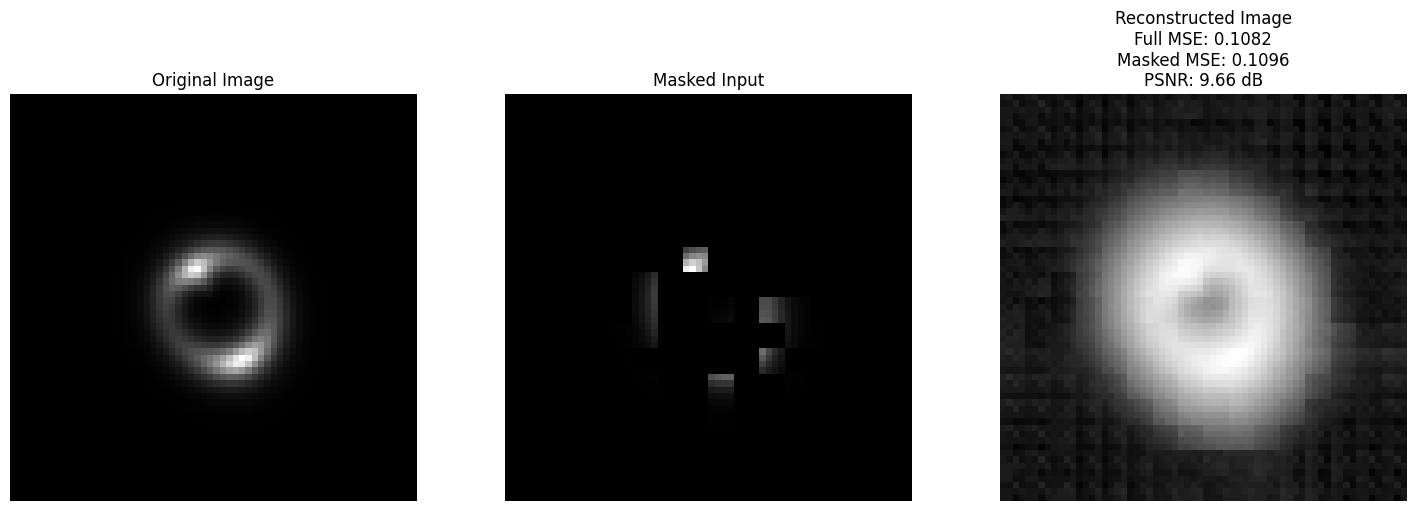

Reconstruction Metrics:
Full Image MSE: 0.108164
Masked Regions MSE: 0.109605
PSNR: 9.66 dB
SSIM: 0.0586
Sample 1
imgs shape: torch.Size([1, 1, 64, 64])
pred shape: torch.Size([1, 256, 16])
mask shape: torch.Size([1, 256])


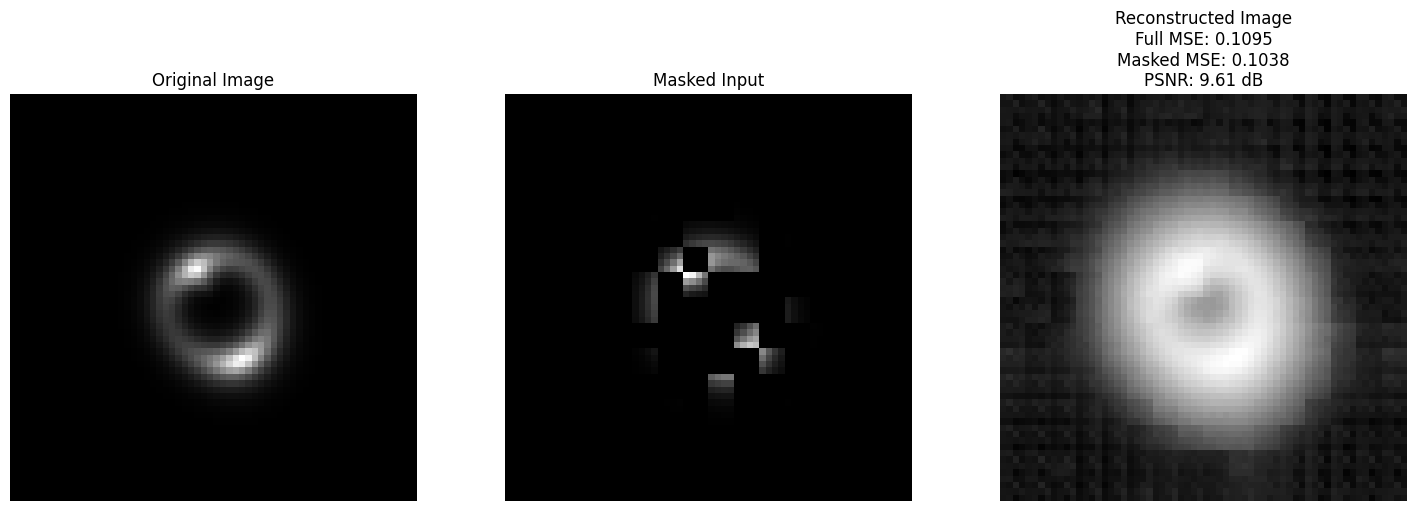

Reconstruction Metrics:
Full Image MSE: 0.109459
Masked Regions MSE: 0.103777
PSNR: 9.61 dB
SSIM: 0.0587


Sample 2
imgs shape: torch.Size([1, 1, 64, 64])
pred shape: torch.Size([1, 256, 16])
mask shape: torch.Size([1, 256])


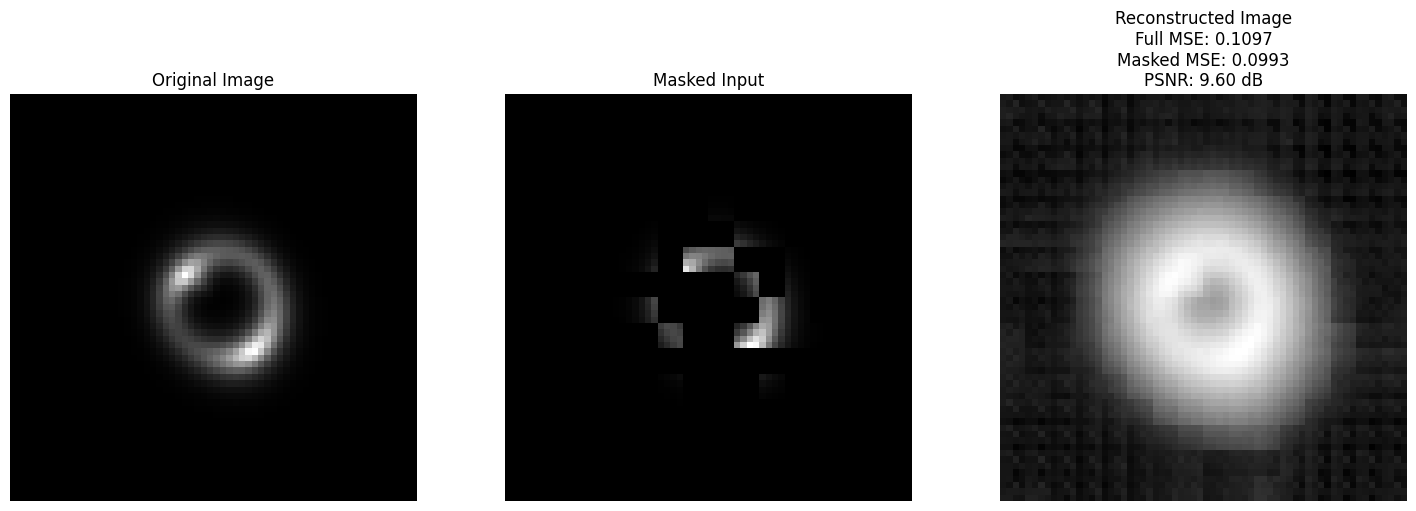

Reconstruction Metrics:
Full Image MSE: 0.109712
Masked Regions MSE: 0.099331
PSNR: 9.60 dB
SSIM: 0.0609


Sample 3
imgs shape: torch.Size([1, 1, 64, 64])
pred shape: torch.Size([1, 256, 16])
mask shape: torch.Size([1, 256])


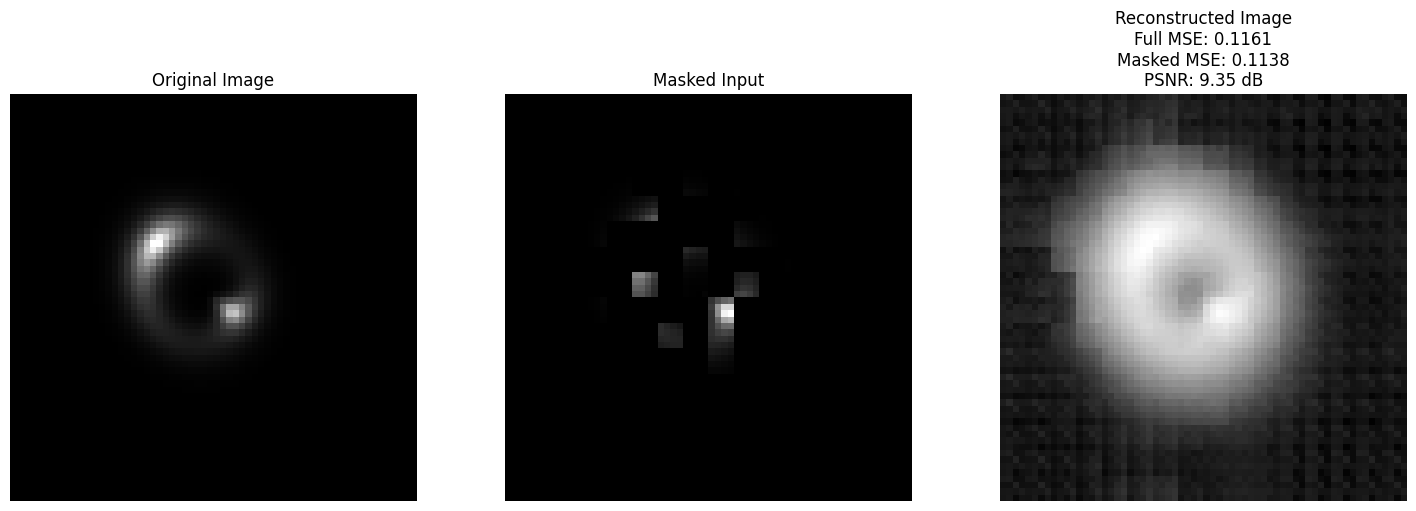

Reconstruction Metrics:
Full Image MSE: 0.116066
Masked Regions MSE: 0.113757
PSNR: 9.35 dB
SSIM: 0.0435


======= Average Metrics Across All Samples =======
Average Full Image MSE: 0.111746
Average Masked Regions MSE: 0.105622
Average PSNR: 9.52 dB
Average SSIM: 0.0543


{'mse': 0.11174575,
 'psnr': 9.519294239322287,
 'ssim': 0.05434174542089384,
 'masked_mse': 0.10562181803915234}

In [20]:
model = mae_vit_base(64)
ckpt = torch.load('/kaggle/working/best_mae_vit_model_256emb_final.pth')
new_state_dict = {key.replace("module.", ""): value for key, value in ckpt.items()}
model.load_state_dict(new_state_dict)
model.eval()  # Set to evaluation mode

sample_img = next(iter(val_dataloader))['img'][0:1]
# sample_img = sample_img.to(dtype=torch.float32)
visualize_mae_reconstruction(model, sample_img, device="cpu")

# For multiple samples:
visualize_multiple_samples(model, val_dataloader, num_samples=3, device="cpu")